# Notebook C - Feature importance analysis 

Tree-based machine learning models, such as decision trees, random forests, and gradient boosting machines (including XGBoost), inherently evaluate the significance of features during the training phase. This evaluation, known as fit-time or intrinsic importance, is model-specific and relies on criteria like the total decrease in impurity for decision trees or the total gain from all splits a feature participates in for ensemble models. Essentially, this approach assesses feature importance based on how integral a feature is to the construction of the model using the training dataset.

On the other hand, SHAP (SHapley Additive exPlanations) values offer a nuanced and theoretically robust method to understand the contribution of features to individual predictions after the model has been trained. Rooted in game theory, specifically through the use of Shapley values, SHAP assigns each feature a 'payout' (or contribution to the prediction) in a fair manner. Unlike fit-time importance, SHAP values can be calculated and applied to datasets other than the one used for training, providing insights into feature contributions at prediction time. This distinction highlights SHAP's versatility and its capability to offer detailed explanations for individual predictions across various datasets, emphasizing its role in interpretability post-model training.

In [1]:
import os
import joblib

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

import shap


In [2]:
# set working directory
os.chdir('/mnt/c/Users/ennas/Desktop/ML_genomics/Project1_PcG/')

In [3]:
# load trained model
xgb_opt_trained = joblib.load( 'models/xgb_opt_trained.joblib')
xgb_opt_trained

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8707077438668258, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.29517518397558595,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05607053766206377,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=3.0781249862572944, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=500,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [4]:
# load features
sel_features = pd.read_csv('data/meta/xgb_selected_features.csv').iloc[:, 0].tolist()

# PcG-associated features
pcg_factors = pd.read_csv('data/meta/Voigt&FroschauerTabS34_PcGassoc_factors.csv').drop_duplicates(subset='gene_symbol')['gene_symbol']
pcg_features = [feature for feature in sel_features for factor in pcg_factors if feature.split('_')[0] == factor]
pcg_features


['Dsp1_1_score', 'su(Hw)_1_score', 'Trl_1_score']

In [5]:
# load data

# training/test dataset
data_FRZI = pd.read_csv('data/processed/FRZI_features_target.csv', index_col=0) 

# aim dataset
data_ORESAM = pd.read_csv('data/processed/ORESAM_features_target.csv', index_col=0)


## 1. Tree-based Models Feature Importance (fit-time)

### 1.1 Gain (impurity reduction)

'Gain' refers to the improvement in accuracy brought by a feature to the branches it is on. More specifically, gain measures the contribution of each feature to the model by calculating the increase in purity that results from splitting a node on that feature. It is a metric used to decide which feature to split on at each step in the construction of the tree. A higher gain value for a feature means it is more important for generating predictions

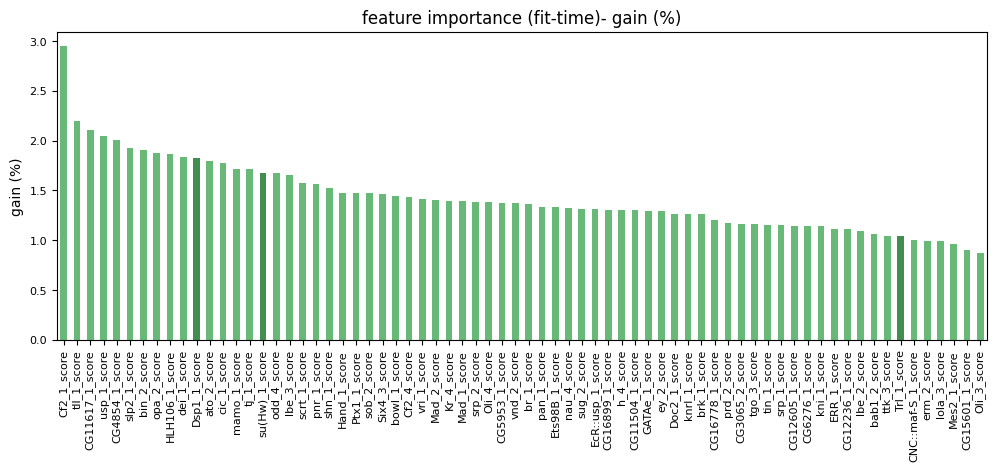

In [6]:
# feature importances - gain (%)
xgb_opt_gain = pd.Series(xgb_opt_trained.feature_importances_* 100, index= sel_features).sort_values()

colors = ['#428E51' if feature in pcg_features else '#68B877' for feature in xgb_opt_gain.index]
fig, ax = plt.subplots(figsize=(12, 4))
xgb_opt_gain.sort_values().plot(kind='bar', ax=ax, color=colors, fontsize=8)
ax.set_title('feature importance (fit-time)- gain (%)', size=12)
ax.set_ylabel('gain (%)', fontsize=10)
ax.invert_xaxis()
plt.savefig('figures/FRZI_xgb_opt_feature_importance_gain.svg')

### 1.2 Coverage (number of observations a given feature affects)

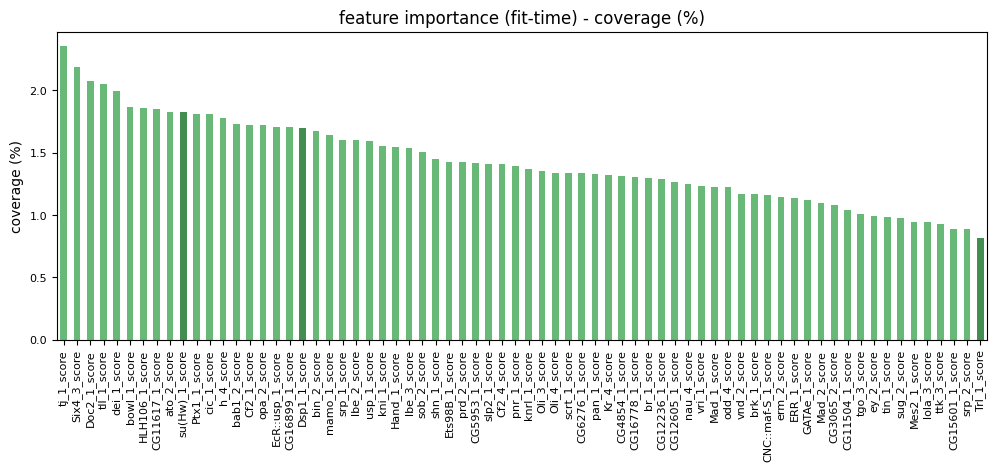

In [7]:
# feature importances - coverage (%)
cov_counts = pd.Series(xgb_opt_trained.get_booster().get_score(importance_type= 'cover')).sort_values()
xgb_opt_cov = cov_counts/ cov_counts.sum() * 100

colors = ['#428E51' if feature in pcg_features else '#68B877' for feature in xgb_opt_cov.index]
fig, ax = plt.subplots(figsize=(12, 4))
xgb_opt_cov.sort_values().plot(kind='bar', ax=ax, color=colors, fontsize=8)
ax.set_title('feature importance (fit-time) - coverage (%)', size=12)
ax.set_ylabel('coverage (%)', fontsize=10)
ax.invert_xaxis()
plt.savefig('figures/FRZI_xgb_opt_feature_importance_cov.svg')


The relatively high number of features suggests that numerous transcription factors contribute to PcG-typical temperature-sensitive expression in a more gene-specific manner, which is also reflected in the comparatively low coverage values of all feature.

## 2. SHAP Feature Importance (predict-time)

Advantages of using SHAP values:

* Global interpretability: SHAP values reveal not just the importance of features but also indicate if a feature's influence on predictions is positive or negative.

* Local interpretability: SHAP values can be calculated for individual predictions, providing insights into how features contribute to specific outcomes. In contrast, other techniques typically offer only aggregated insights across the entire dataset.

* SHAP values are applicable for explaining a wide array of models, such as linear models (like linear regression), tree-based models (for instance, XGBoost), and neural networks, offering a broader applicability than many other techniques that are restricted to a limited set of model types.

To draw more biologically relevant conclusions about the impact of individual features (i.e., transcription factor binding site (TFBS) motifs) on model predictions, the calculation of SHAP-based feature importances will be confined to observations that were correctly predicted by the model.

In [8]:
# extract correctly predicted expression responses from the two datasets:

# FRZI (1469 correctly predicted out of 1488)
data_FRZI_correct_pred = data_FRZI[sel_features + ['TSE']].copy()
data_FRZI_correct_pred['pred_TSE'] = pd.Series(xgb_opt_trained.predict(data_FRZI[sel_features]), index=data_FRZI.index)
data_FRZI_correct_pred = data_FRZI_correct_pred[data_FRZI_correct_pred['TSE'] == data_FRZI_correct_pred['pred_TSE']]


# ORSAM (880 correctly predicted out of 1108)
data_ORESAM_correct_pred = data_ORESAM[sel_features + ['TSE']].copy()
data_ORESAM_correct_pred['pred_TSE'] = pd.Series(xgb_opt_trained.predict(data_ORESAM[sel_features]), index=data_ORESAM.index)
data_ORESAM_correct_pred = data_ORESAM_correct_pred[data_ORESAM_correct_pred['TSE'] == data_ORESAM_correct_pred['pred_TSE']]



In [9]:
# calculate SHAP values:

# initialize explainer
explainer = shap.TreeExplainer(xgb_opt_trained)

# calculate SHAP values FRZI dataset (training/test)
shap_values_FRZI = explainer(data_FRZI_correct_pred[sel_features])
shap_values_FRZI_df = pd.DataFrame(shap_values_FRZI.values, columns=sel_features, index=data_FRZI_correct_pred[sel_features].index)


# calculate SHAP values ORESAM dataset (aim)
shap_values_ORESAM = explainer(data_ORESAM_correct_pred[sel_features])
shap_values_ORESAM_df = pd.DataFrame(shap_values_ORESAM.values, columns=sel_features, index=data_ORESAM_correct_pred[sel_features].index)


### 2.1 SHAP values - Global importance of features

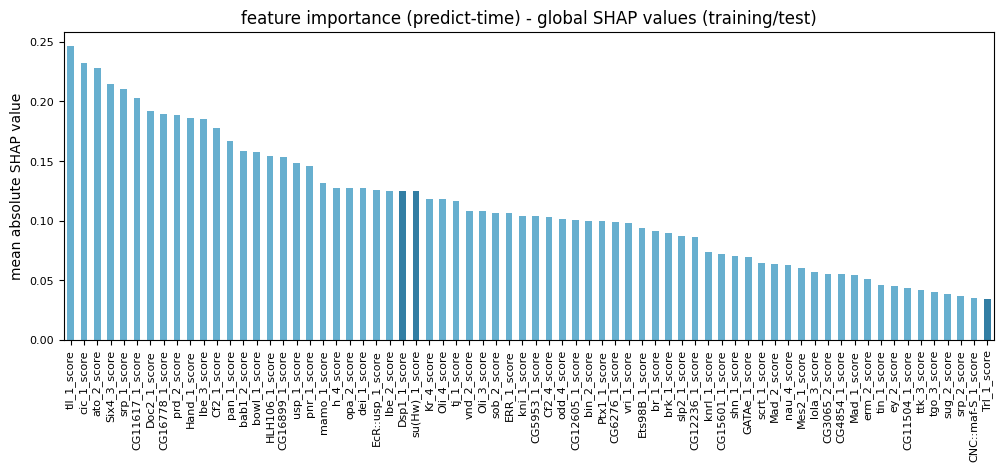

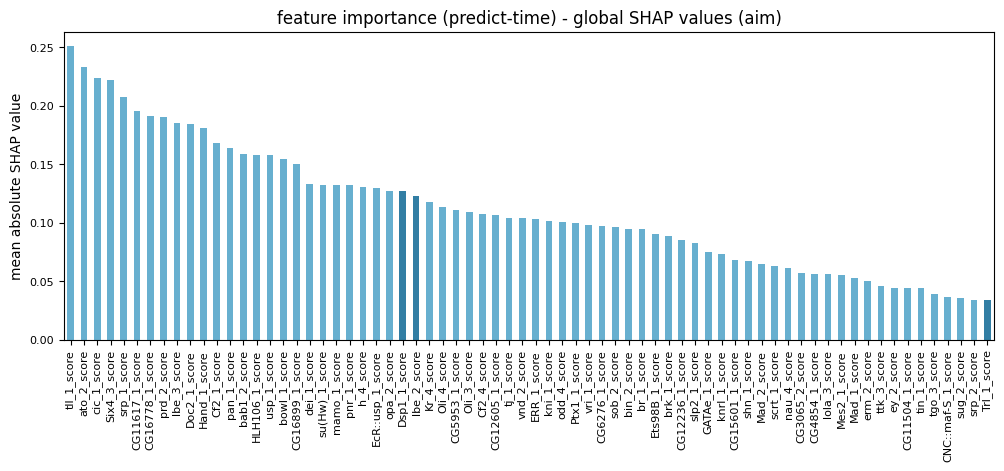

In [10]:
# FRZI dataset (training/test):

# (custom-script instead of shap.summary_plot(shap_values_FRZI, data_FRZI[sel_features], plot_type='bar', max_display=70))
mean_abs_shap_FRZI = np.abs(shap_values_FRZI_df).mean().sort_values()

colors = ['#327EA4' if feature in pcg_features else '#67AFCF' for feature in mean_abs_shap_FRZI.index]
fig, ax = plt.subplots(figsize=(12, 4))
mean_abs_shap_FRZI.sort_values().plot(kind='bar', ax=ax, color=colors, fontsize=8)
ax.set_title('feature importance (predict-time) - global SHAP values (training/test)', size=12)
ax.set_ylabel('mean absolute SHAP value', fontsize=10)
ax.invert_xaxis()
plt.savefig('figures/FRZI_xgb_opt_feature_importance_shap_global_absmean.svg')


# ORESAM dataset (aim):

# (custom-script instead of shap.summary_plot(shap_values_ORESAM, data_ORESAM[sel_features], plot_type='bar', max_display=70))
mean_abs_shap_ORESAM = np.abs(shap_values_ORESAM_df).mean().sort_values()

colors = ['#327EA4' if feature in pcg_features else '#67AFCF' for feature in mean_abs_shap_FRZI.index]
fig, ax = plt.subplots(figsize=(12, 4))
mean_abs_shap_ORESAM.sort_values().plot(kind='bar', ax=ax, color=colors, fontsize=8)
ax.set_title('feature importance (predict-time) - global SHAP values (aim)', size=12)
ax.set_ylabel('mean absolute SHAP value', fontsize=10)
ax.invert_xaxis()
plt.savefig('figures/ORESAM_xgb_opt_feature_importance_shap_global_absmean.svg')




### 2.2 SHAP values - Impact direction of features on prediction:

In [11]:
# create custom colormap
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', ['#58A5CC', '#CA0020'], N=100)

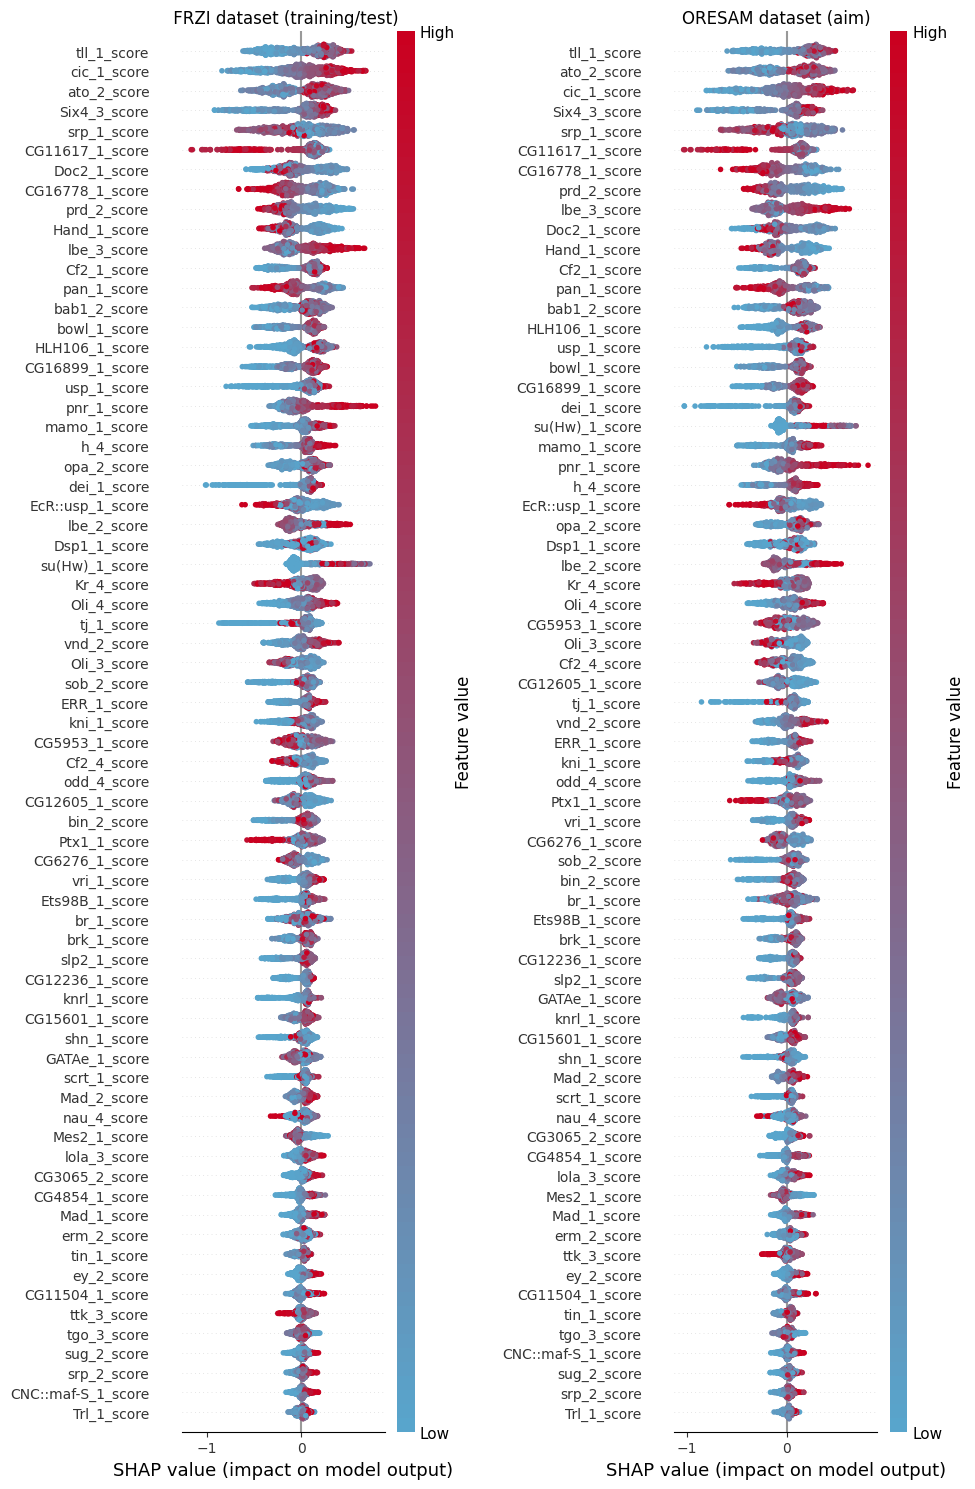

In [12]:
# plot beeswarm summary plot - feature impact direction and relationship to feature value

fig = plt.figure()

# FRZI dataset (training/test) 
ax0 = fig.add_subplot(121) 
shap.summary_plot(shap_values_FRZI, data_FRZI_correct_pred[sel_features], max_display=70, cmap=custom_cmap, show = False)
ax0.set_title(' FRZI dataset (training/test)') 
ax0.tick_params(axis='y', labelsize=10)
ax0.tick_params(axis='x', labelsize=10)

# ORESAM dataset (aim) 
ax1 = fig.add_subplot(122)
shap.summary_plot(shap_values_ORESAM, data_ORESAM_correct_pred[sel_features], max_display=70, cmap=custom_cmap, show = False)
ax1.set_title('ORESAM dataset (aim)') 
ax1.tick_params(axis='y', labelsize=10)
ax1.tick_params(axis='x', labelsize=10)

plt.gcf().set_size_inches(10, 15)
plt.tight_layout()
plt.savefig('figures/FRZIORESAM_xgb_opt_feature_importance_shap_global_beeswarm.svg', bbox_inches='tight')

The motif scores associated with the tailless (tll) transcription factor are highly predictive of temperature-dependent gene expression across both datasets. Higher tll motif scores—reflecting stronger binding affinity—tend to predict gene overexpression at lower temperatures, while lower motif scores are associated with reduced overexpression in response to low temperatures.

### 2.3 SHAP values - Feature interaction

While SHAP values can describe the importance of a feature individually, SHAP interaction values decompose the model output into pairwise interactions, providing a more detailed view of how features work together to impact the model's predictions. This is particularly pertinent in a biological context, where transcription factors may need to interact synergistically or antagonistically to modulate gene expression, reflecting the complexity of regulatory mechanisms at the genomic level.


SHAP values quantify how each feature influences a model's prediction. SHAP interaction values go a step further, separating a feature's independent impact from its interactive effects with other features. When interactions are present, main effects differ from the individual SHAP values.

In [13]:
# calculate SHAP interaction values
shap_interaction_values_FRZI = explainer.shap_interaction_values(data_FRZI_correct_pred[sel_features])
shap_interaction_values_ORESAM = explainer.shap_interaction_values(data_ORESAM_correct_pred[sel_features])


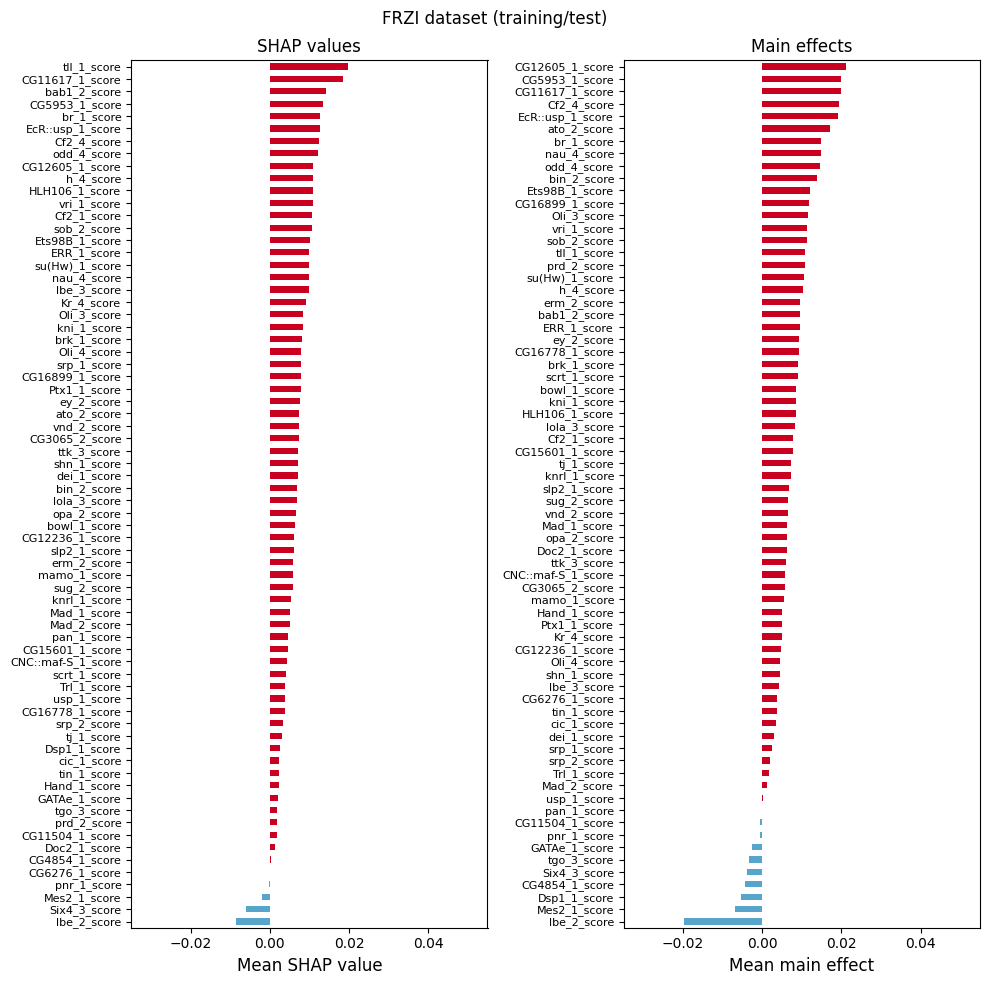

In [14]:
# plot mean SHAP values and mean main effects - FRZI dataset (training/test):

# calulate mean SHAP values
mean_shap_values_FRZI = pd.Series(np.mean(shap_values_FRZI.values, axis=0), index=sel_features).sort_values()
# calulate main effects
mean_interaction_values_FRZI = np.mean(shap_interaction_values_FRZI, axis=0) # diagonal of interaction matrix corresponds to main effects
mean_main_effects_FRZI = pd.Series(np.diag(mean_interaction_values_FRZI), index=sel_features).sort_values()


# plot
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 10))  

mean_shap_values_FRZI.sort_values().plot(kind='barh', ax=ax0, color= ['#58A5CC' if x <= 0 else '#CA0020' for x in mean_shap_values_FRZI])
ax0.set_title('SHAP values', fontsize=12)
ax0.set_xlabel('Mean SHAP value', fontsize=12)
ax0.tick_params(axis='y', labelsize=8)
ax0.set_xlim([-0.035, 0.055]) 


mean_main_effects_FRZI.plot(kind='barh', ax=ax1, color= ['#58A5CC' if x <= 0 else '#CA0020' for x in mean_main_effects_FRZI])
ax1.set_title('Main effects', fontsize=12)
ax1.set_xlabel('Mean main effect', fontsize=12)
ax1.tick_params(axis='y', labelsize=8)
ax1.set_xlim([-0.035, 0.055]) 

fig.suptitle('FRZI dataset (training/test)', fontsize=12)
plt.tight_layout()
plt.savefig('figures/FRZI_xgb_opt_shap_interactions_mean_values_main_effects.svg', bbox_inches='tight')


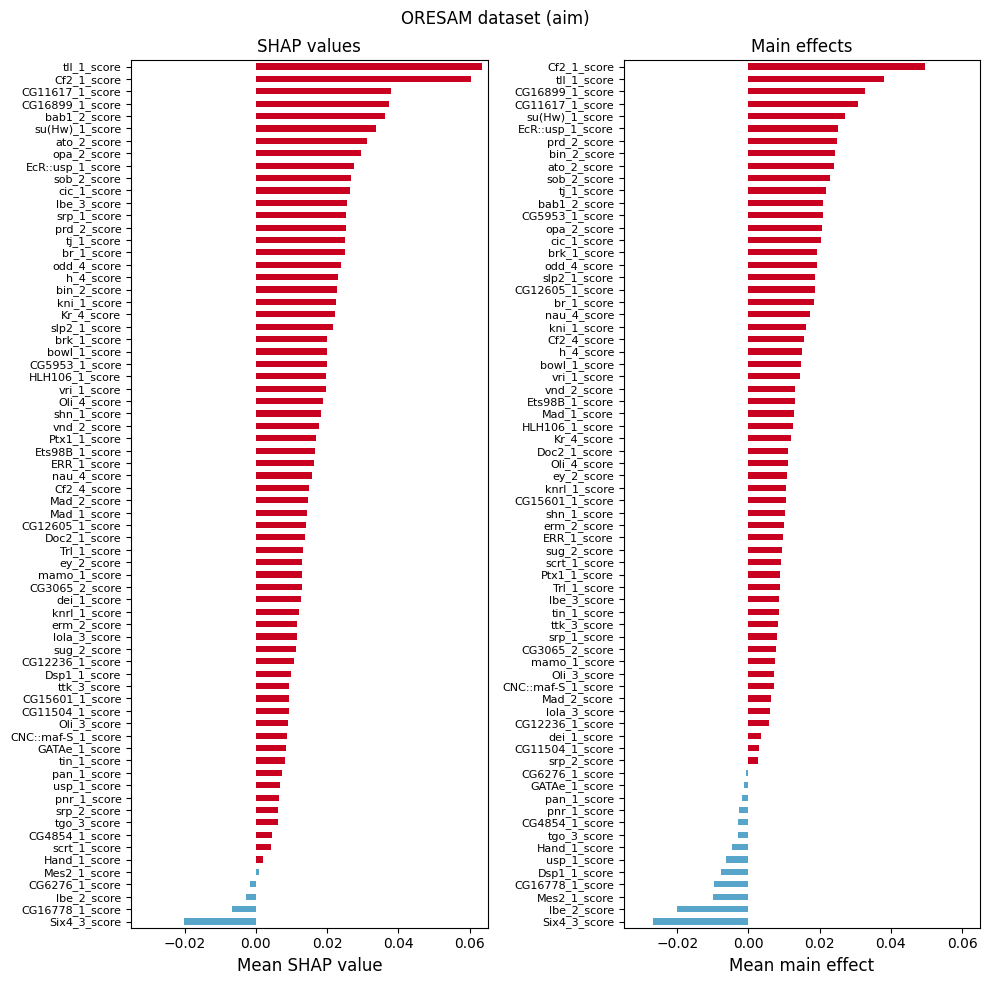

In [15]:
# plot mean SHAP values and mean main effects - ORESAM dataset (aim):

# calulate mean SHAP values
mean_shap_values_ORESAM= pd.Series(np.mean(shap_values_ORESAM.values, axis=0), index=sel_features).sort_values()
# calulate main effects
mean_interaction_values_ORESAM = np.mean(shap_interaction_values_ORESAM, axis=0) # diagonal of interaction matrix corresponds to main effects
mean_main_effects_ORESAM = pd.Series(np.diag(mean_interaction_values_ORESAM), index=sel_features).sort_values()


# plot
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 10))  

mean_shap_values_ORESAM.sort_values().plot(kind='barh', ax=ax0, color= ['#58A5CC' if x <= 0 else '#CA0020' for x in mean_shap_values_FRZI])
ax0.set_title('SHAP values', fontsize=12)
ax0.set_xlabel('Mean SHAP value', fontsize=12)
ax0.tick_params(axis='y', labelsize=8)
ax0.set_xlim([-0.035, 0.065]) 

mean_main_effects_ORESAM.plot(kind='barh', ax=ax1, color= ['#58A5CC' if x <= 0 else '#CA0020' for x in mean_main_effects_ORESAM])
ax1.set_title('Main effects', fontsize=12)
ax1.set_xlabel('Mean main effect', fontsize=12)
ax1.tick_params(axis='y', labelsize=8)
ax1.set_xlim([-0.035, 0.065]) 

fig.suptitle('ORESAM dataset (aim)', fontsize=12)
plt.tight_layout()
plt.savefig('figures/ORESAM_xgb_opt_shap_interactions_mean_values_main_effects.svg', bbox_inches='tight')


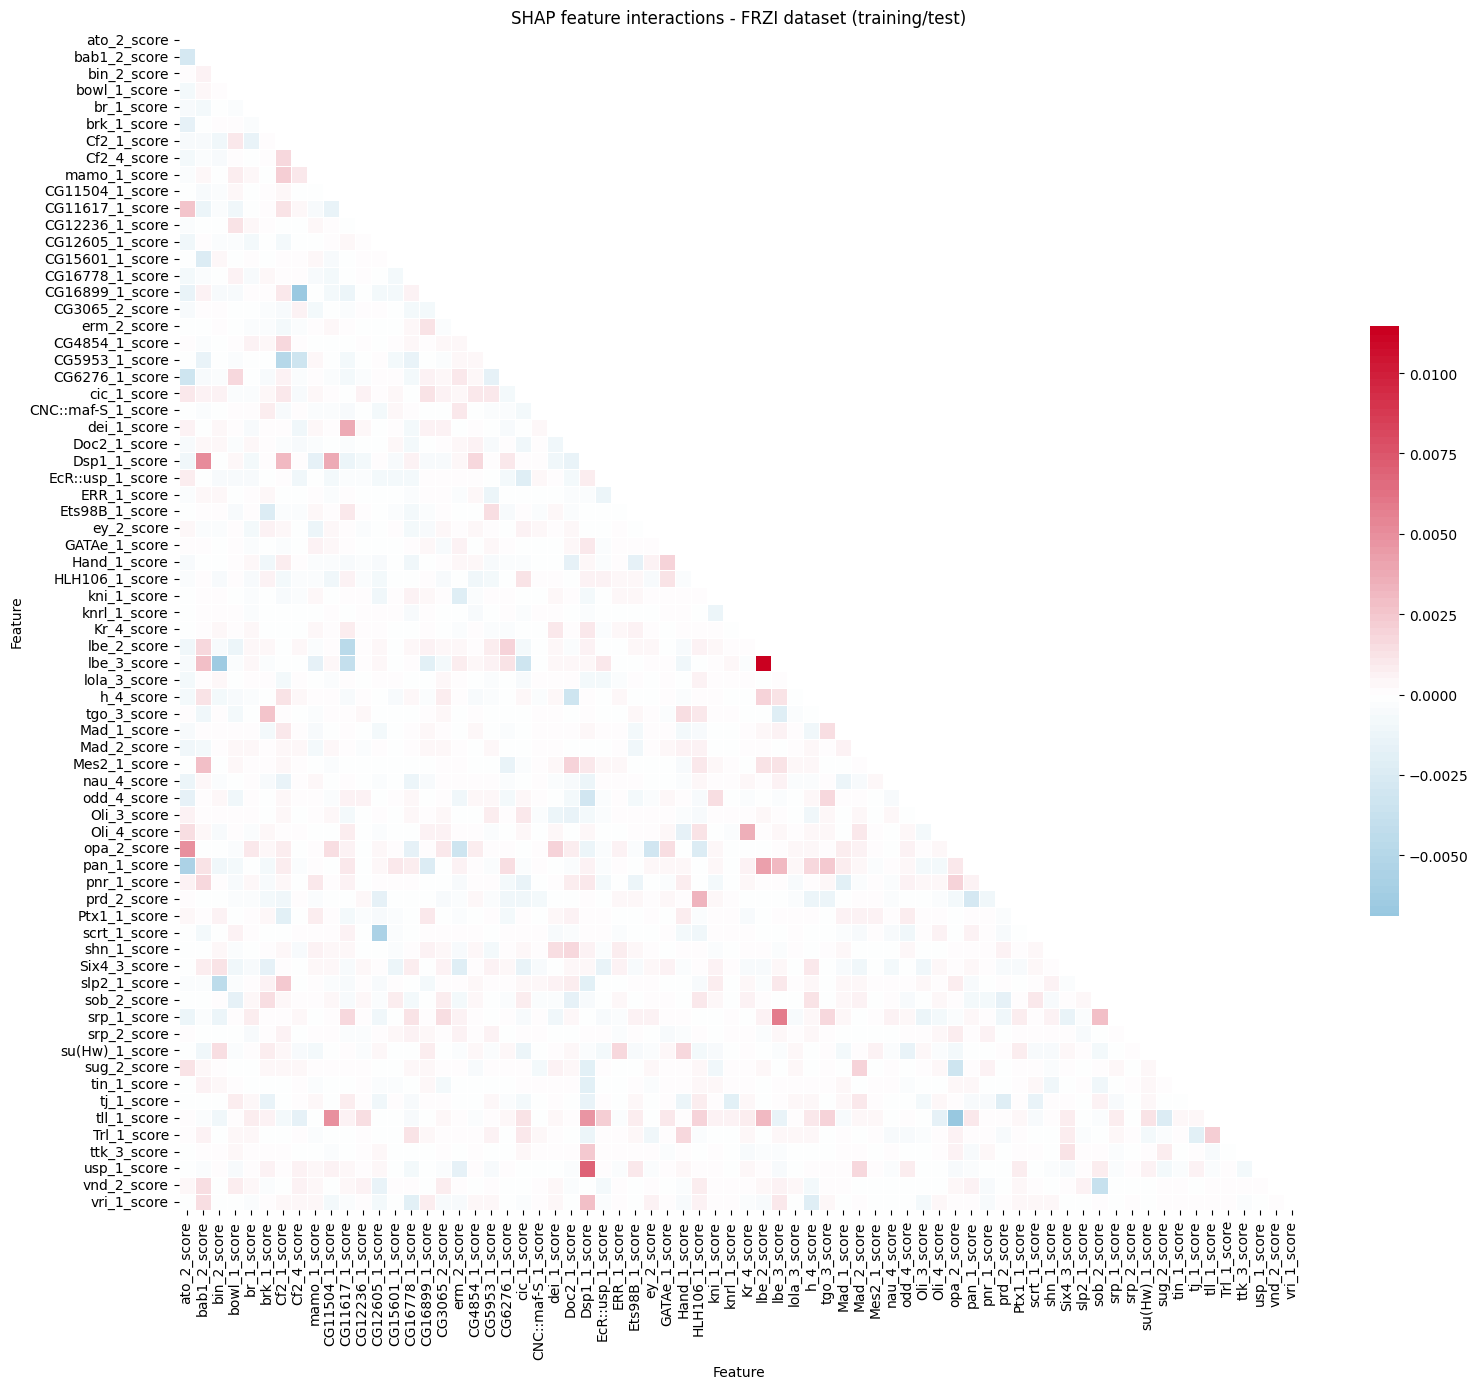

In [16]:
# heatmap mean interaction effects - FRZI dataset (training/test):  

# mean interaction values and 
mean_interaction_values_FRZI_df = pd.DataFrame(np.mean(shap_interaction_values_FRZI, axis=0),index=sel_features,columns=sel_features)

# diagonal correspond main effect of each feature on prediction, off diagonal values are halved interactions values 
# (interaction effect  evenly split across the two contributing features) - multiply interaction effects by 2
mean_interaction_values_FRZI_df.where(mean_interaction_values_FRZI_df.values == np.diagonal(mean_interaction_values_FRZI_df),mean_interaction_values_FRZI_df.values*2,inplace=True)

plt.figure(figsize=(16, 14))


custom_cmap2 = LinearSegmentedColormap.from_list('custom_cmap', ['#58A5CC', '#FFFFFF', '#CA0020'], N=100)
sns.heatmap(mean_interaction_values_FRZI_df, 
            mask=np.triu(np.ones_like(np.mean(shap_interaction_values_FRZI, axis=0), dtype=bool)), # diagonal corresponds to the mean main effect of each feature (comment this line for including main effects)
            cmap=custom_cmap2, center=0,
            fmt='.2f', linewidths=.5, cbar_kws={'shrink': .5})

plt.xticks(rotation=90)
plt.yticks(rotation=0)

plt.title('SHAP feature interactions - FRZI dataset (training/test)')
plt.xlabel('Feature')
plt.ylabel('Feature')

plt.tight_layout()
plt.savefig('figures/FRZI_shap_mean_interactions_values.svg', bbox_inches='tight')

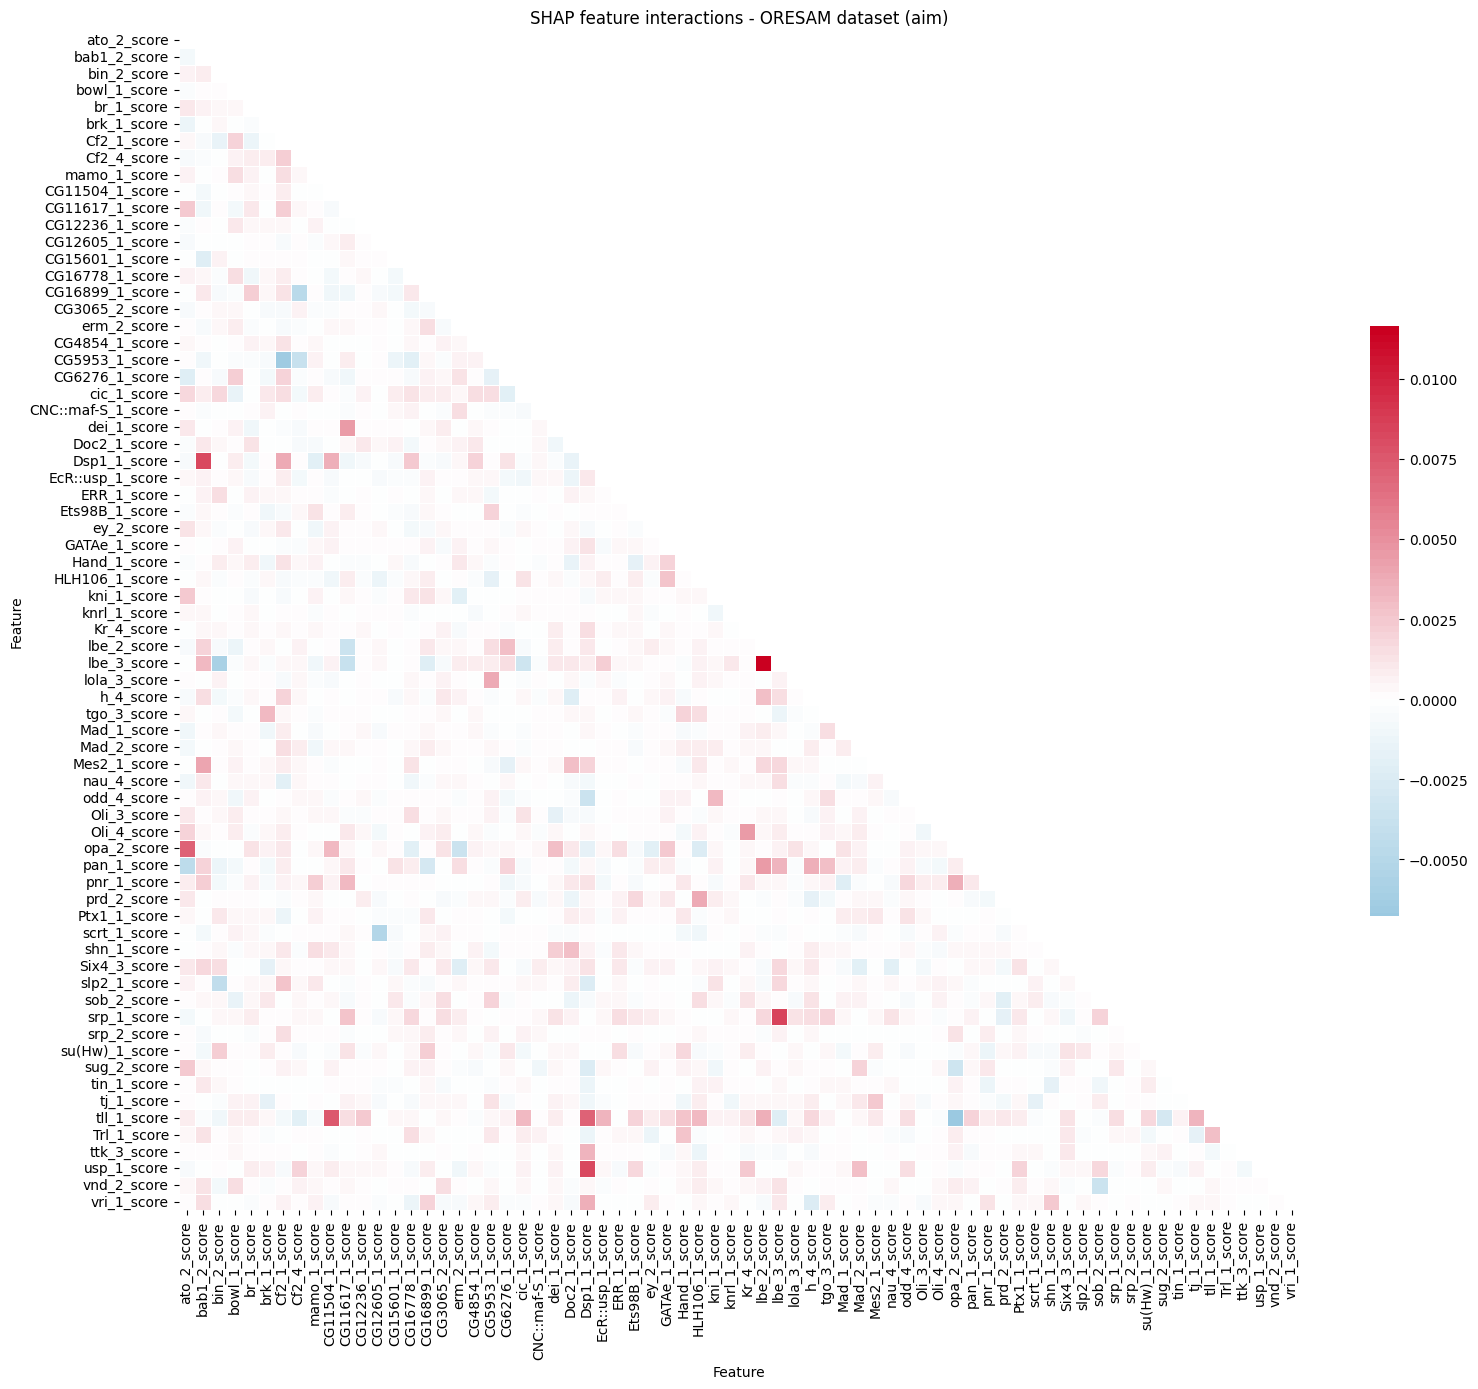

In [17]:
# heatmap mean interaction effects - ORESAM dataset (aim):  

# mean interaction values and 
mean_interaction_values_ORESAM_df = pd.DataFrame(np.mean(shap_interaction_values_ORESAM, axis=0),index=sel_features,columns=sel_features)

# diagonal correspond main effect of each feature on prediction, off diagonal values are halved interactions values 
# (interaction effect  evenly split across the two contributing features) - multiply interaction effects by 2
mean_interaction_values_ORESAM_df.where(mean_interaction_values_ORESAM_df.values == np.diagonal(mean_interaction_values_ORESAM_df),mean_interaction_values_ORESAM_df.values*2,inplace=True)

plt.figure(figsize=(16, 14))


custom_cmap2 = LinearSegmentedColormap.from_list('custom_cmap', ['#58A5CC', '#FFFFFF', '#CA0020'], N=100)
sns.heatmap(mean_interaction_values_ORESAM_df, 
            mask=np.triu(np.ones_like(np.mean(mean_interaction_values_ORESAM, axis=0), dtype=bool)), # diagonal corresponds to the mean main effect of each feature (comment this line for including main effects)
            cmap=custom_cmap2, center=0,
            fmt='.2f', linewidths=.5, cbar_kws={'shrink': .5})


plt.xticks(rotation=90)
plt.yticks(rotation=0)

plt.title('SHAP feature interactions - ORESAM dataset (aim)')
plt.xlabel('Feature')
plt.ylabel('Feature')

plt.tight_layout()
plt.savefig('figures/ORESAM_shap_mean_interactions_values.svg', bbox_inches='tight')

##### Interaction of the two DNA-binding motifs of lbe:

For both datasets, the strongest interaction effects are observed between the two binding motifs of the transcription factor encoded by *lbe*.

In [73]:
# infer minimum and maximum interaction effects

# FRZI dataset (training/test):
df = mean_interaction_values_FRZI_df.copy()
np.fill_diagonal(df.values, np.nan) # replace the diagonal elements with NaN to exclude main effects from the max calculation
print('FRZI dataset (training/test):')
print('Maximum interaction value:', df.max().max())
print('Location of maximum interaction value:', df.stack().idxmax())
print('Minimum interaction value:', df.min().max())
print('Location of minimum interaction value:', df.stack().idxmin(), '\n')

#ORESAM dataset (aim):
df = mean_interaction_values_ORESAM_df.copy()
np.fill_diagonal(df.values, np.nan) # replace the diagonal elements with NaN to exclude main effects from the max calculation
print('ORESAM dataset (aim):')
print('Maximum interaction value:', df.max().max())
print('Location of maximum interaction value:', df.stack().idxmax())
print('Minimum interaction value:', df.min().max())
print('Location of minimum interaction value:', df.stack().idxmin())

FRZI dataset (training/test):
Maximum interaction value: 0.011461097
Location of maximum interaction value: ('lbe_3_score', 'lbe_2_score')
Minimum interaction value: -0.0005611215
Location of minimum interaction value: ('tll_1_score', 'opa_2_score') 

ORESAM dataset (aim):
Maximum interaction value: 0.011641977
Location of maximum interaction value: ('lbe_2_score', 'lbe_3_score')
Minimum interaction value: -0.00048639937
Location of minimum interaction value: ('opa_2_score', 'tll_1_score')


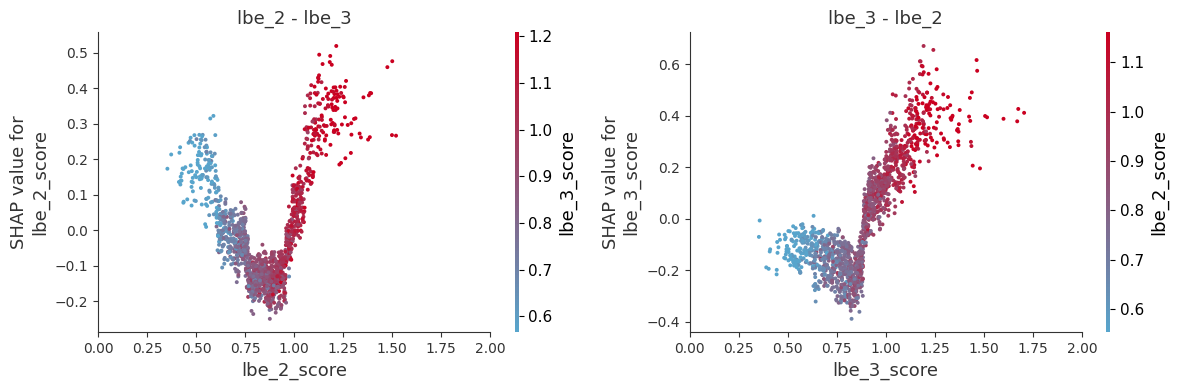

In [18]:
# dependence plots lbe_2_score & lbe_3_score - FRZI dataset (training/test)
fig = plt.figure()

# lbe_2
ax0 = fig.add_subplot(121) 
shap.dependence_plot('lbe_2_score', shap_values_FRZI.values, data_FRZI_correct_pred[sel_features], interaction_index='lbe_3_score',
                     cmap=custom_cmap, dot_size=8, title='lbe_2 - lbe_3', xmin=0, xmax=2, ax = ax0, show=False)
ax0.tick_params(axis='y', labelsize=10)
ax0.tick_params(axis='x', labelsize=10)

# lbe_3 
ax1 = fig.add_subplot(122)
shap.dependence_plot('lbe_3_score', shap_values_FRZI.values, data_FRZI_correct_pred[sel_features], interaction_index='lbe_2_score',
                     cmap=custom_cmap, dot_size=8, title='lbe_3 - lbe_2', xmin=0, xmax=2, ax = ax1, show=False)
ax1.tick_params(axis='y', labelsize=10)
ax1.tick_params(axis='x', labelsize=10)

plt.gcf().set_size_inches(12, 4)
plt.tight_layout()
plt.savefig('figures/ORESAM_xgb_opt_shap_interaction_lbe2_lbe3_dependence.svg', bbox_inches='tight')
plt.savefig('figures/FRZI_xgb_opt_shap_interaction_lbe2_lbe3_dependence.svg', bbox_inches='tight')

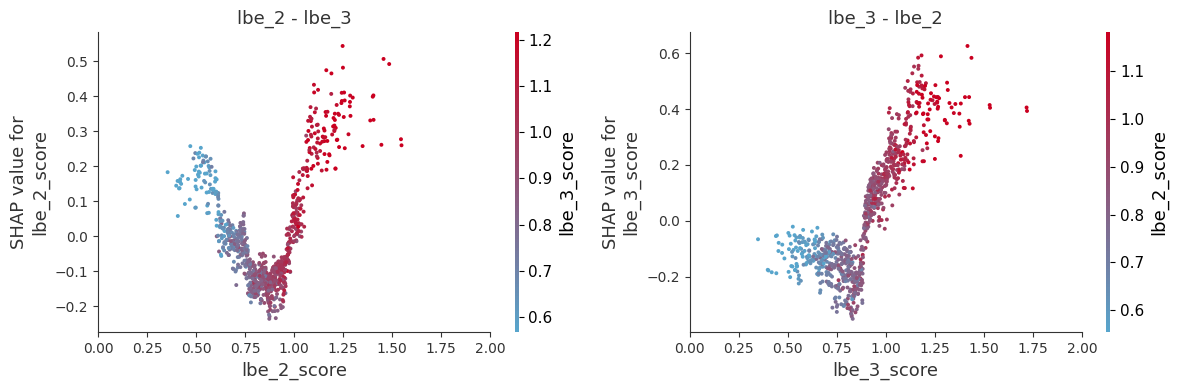

In [19]:
# dependence plots lbe_2_score & lbe_3_score - ORESAM dataset (aim)
fig = plt.figure()

# lbe_2
ax0 = fig.add_subplot(121) 
shap.dependence_plot('lbe_2_score', shap_values_ORESAM.values, data_ORESAM_correct_pred[sel_features], interaction_index='lbe_3_score',
                     cmap=custom_cmap, dot_size=8, title='lbe_2 - lbe_3', xmin=0, xmax=2, ax = ax0, show=False)
ax0.tick_params(axis='y', labelsize=10)
ax0.tick_params(axis='x', labelsize=10)

# lbe_3 
ax1 = fig.add_subplot(122)
shap.dependence_plot('lbe_3_score', shap_values_ORESAM.values, data_ORESAM_correct_pred[sel_features], interaction_index='lbe_2_score',
                     cmap=custom_cmap, dot_size=8, title='lbe_3 - lbe_2', xmin=0, xmax=2, ax = ax1, show=False)
ax1.tick_params(axis='y', labelsize=10)
ax1.tick_params(axis='x', labelsize=10)

plt.gcf().set_size_inches(12, 4)
plt.tight_layout()
plt.savefig('figures/ORESAM_xgb_opt_shap_interaction_lbe2_lbe3_dependence.svg', bbox_inches='tight')

Higher binding affinity scores for both 'lbe_2' and 'lbe_3' motifs are associated with more substantial positive SHAP values, which implies a stronger predictive influence on the model's output for overexpression at lower temperatures (class 1). When 'lbe_2' and 'lbe_3' motifs both have higher binding affinities, there is a synergistic effect that amplifies the likelihood of gene overexpression at lower temperatures.
Conversely, lower scores for either motif might diminish this predictive effect.



##### Interactions of Polycomb Group (PcG) recruiter Dsp1:

The association between individual SHAP values for the Dsp1 TFBS motif and its binding affinity scores is complex. Despite a positive average SHAP value, the mean main effect is negative (see barplots above). This suggests that the impact of Dsp1 on the model's output is influenced by interactions with other transcription factors rather than its binding affinity alone.

In [20]:
# calulate mean interaction values - Dsp1 & other TFs (value of Dsp1 motif itself corresponds to main effect)
dsp1_shap_interaction_values_FRZI = shap_interaction_values_FRZI[:, sel_features.index('Dsp1_1_score'), :]
dsp1_shap_interaction_values_FRZI_mean = pd.Series(dsp1_shap_interaction_values_FRZI.mean(axis=0), index=sel_features)
dsp1_shap_interaction_values_FRZI_mean.sort_values()

Dsp1_1_score      -0.005424
odd_4_score       -0.001554
sug_2_score       -0.000989
slp2_1_score      -0.000965
tin_1_score       -0.000899
                     ...   
Cf2_1_score        0.001603
CG11504_1_score    0.001864
tll_1_score        0.002296
bab1_2_score       0.002566
usp_1_score        0.003449
Length: 70, dtype: float32

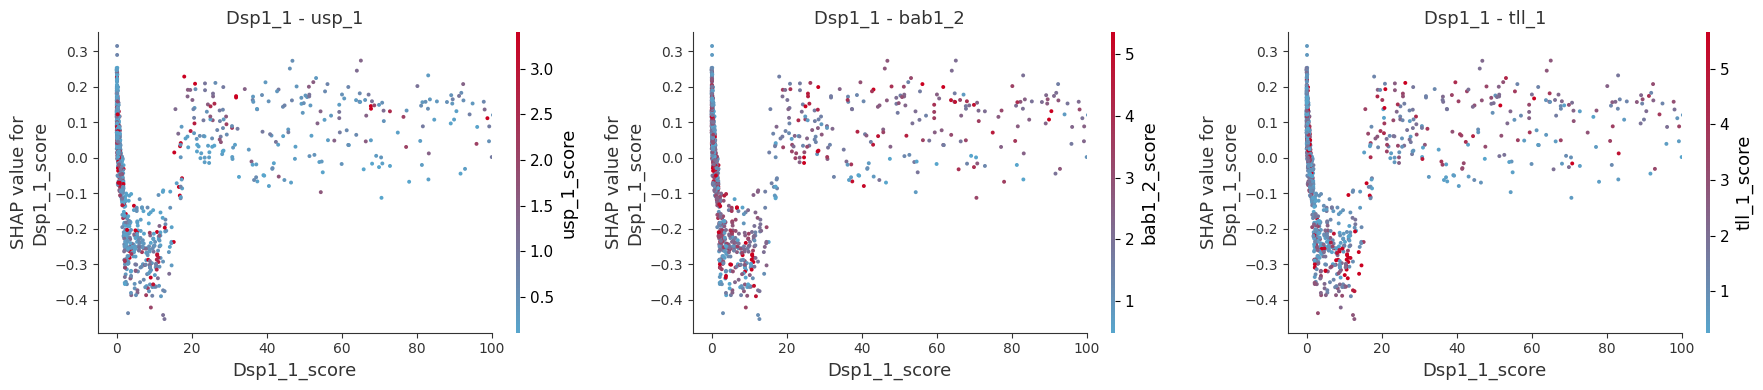

In [21]:
# dependence plots Dsp1 with TOP3 interacting features -FRZI dataset (training/test)

fig = plt.figure()

# Dsp1_1 - usp_1
ax0 = fig.add_subplot(131) 
shap.dependence_plot('Dsp1_1_score', shap_values_FRZI.values, data_FRZI_correct_pred[sel_features], interaction_index='usp_1_score',
                     cmap=custom_cmap, dot_size=8, title='Dsp1_1 - usp_1', xmax=100, ax = ax0, show=False)
ax0.tick_params(axis='y', labelsize=10)
ax0.tick_params(axis='x', labelsize=10)

# Dsp1_1 - bab1_2 
ax1 = fig.add_subplot(132)
shap.dependence_plot('Dsp1_1_score', shap_values_FRZI.values, data_FRZI_correct_pred[sel_features], interaction_index='bab1_2_score',
                     cmap=custom_cmap, dot_size=8, title='Dsp1_1 - bab1_2', xmax=100,  ax = ax1, show=False)
ax1.tick_params(axis='y', labelsize=10)
ax1.tick_params(axis='x', labelsize=10)


# Dsp1_1 - tll_1 
ax2 = fig.add_subplot(133)
shap.dependence_plot('Dsp1_1_score', shap_values_FRZI.values, data_FRZI_correct_pred[sel_features], interaction_index='tll_1_score',
                     cmap=custom_cmap, dot_size=8, title='Dsp1_1 - tll_1', xmax=100,  ax = ax2, show=False)
ax2.tick_params(axis='y', labelsize=10)
ax2.tick_params(axis='x', labelsize=10)

plt.gcf().set_size_inches(18, 4)
plt.tight_layout()
plt.savefig('figures/FRZI_xgb_opt_shap_interaction_Dsp1_dependence.svg', bbox_inches='tight')

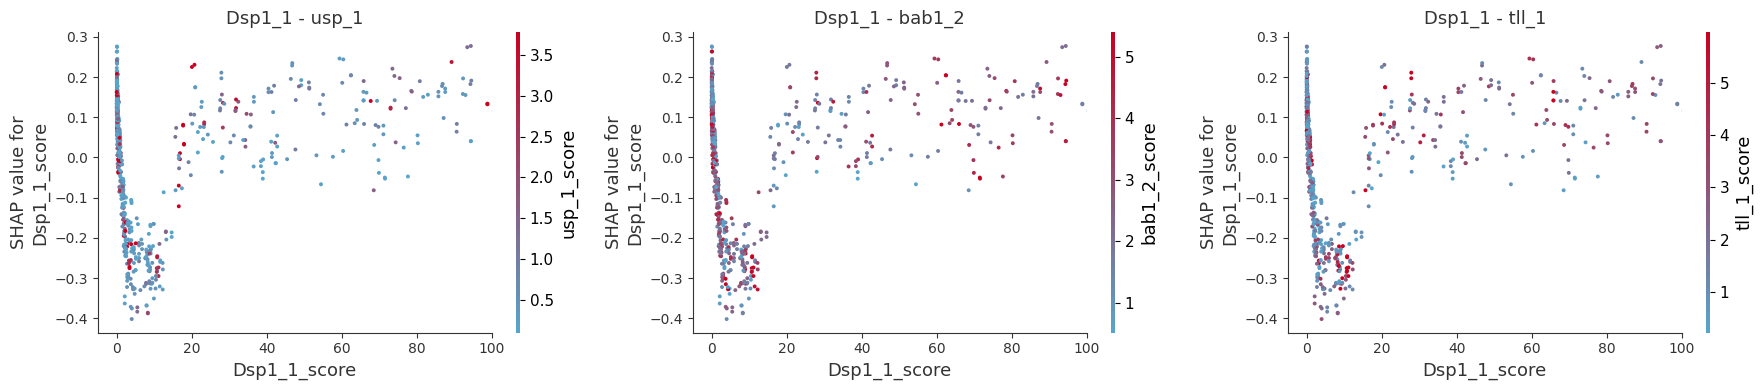

In [22]:
# dependence plots Dsp1 with TOP3 interacting features - ORESAM dataset (aim) 


fig = plt.figure()

# Dsp1_1 - usp_1
ax0 = fig.add_subplot(131) 
shap.dependence_plot('Dsp1_1_score', shap_values_ORESAM.values, data_ORESAM_correct_pred[sel_features], interaction_index='usp_1_score',
                     cmap=custom_cmap, dot_size=8, title='Dsp1_1 - usp_1', xmax=100, ax = ax0, show=False)
ax0.tick_params(axis='y', labelsize=10)
ax0.tick_params(axis='x', labelsize=10)

# Dsp1_1 - bab1_2 
ax1 = fig.add_subplot(132)
shap.dependence_plot('Dsp1_1_score', shap_values_ORESAM.values, data_ORESAM_correct_pred[sel_features], interaction_index='bab1_2_score',
                     cmap=custom_cmap, dot_size=8, title='Dsp1_1 - bab1_2', xmax=100,  ax = ax1, show=False)
ax1.tick_params(axis='y', labelsize=10)
ax1.tick_params(axis='x', labelsize=10)


# Dsp1_1 - tll_1 
ax2 = fig.add_subplot(133)
shap.dependence_plot('Dsp1_1_score', shap_values_ORESAM.values, data_ORESAM_correct_pred[sel_features], interaction_index='tll_1_score',
                     cmap=custom_cmap, dot_size=8, title='Dsp1_1 - tll_1', xmax=100,  ax = ax2, show=False)
ax2.tick_params(axis='y', labelsize=10)
ax2.tick_params(axis='x', labelsize=10)

plt.gcf().set_size_inches(18, 4)
plt.tight_layout()
plt.savefig('figures/ORESAM_xgb_opt_shap_interaction_Dsp1_dependence.svg', bbox_inches='tight')


The SHAP values seem to be widely dispersed vertically for a given Dsp1_1 score, this indicates that the interaction with the other motif (e.g., usp_1, bab1_2, tll_1) varies significantly across observations, suggesting a complex interaction that may depend on other factors not shown in these plots. 

### 2.4 SHAP values - Feature impact on prediction for specific genes

#### Features' impact on prediction for specific genes - cohort plots:

In [23]:
# function to plot group-specific impact of features on prediction (group-specific, ie. strain- or population-specific)
def get_individual_bar_cohort(model, data, features, gene, n_features=20, figsize=(10,20), filename=None):
    '''
    Generates and displays a bar plot showing the group-specific impact of features on model predictions for a specified gene. 
    It uses SHAP values to quantify the impact. The function first identifies the data points corresponding to the specified gene, 
    then calculates and prints both the predicted and actual values for these points. Subsequently, it calculates SHAP values 
    for the entire dataset, defines cohorts for each group for the specified and one comprised of all other genes from all groups,
    and plots the mean SHAP values for the top N features affecting the specified gene.

    Args:
        model (any): Trained machine learning model compatible with SHAP, used for making predictions and computing SHAP values.
        data (DataFrame): DataFrame containing the dataset with features and the target column, as well as an index including the gene name.
        features (list): List of feature names in the data used for making predictions.
        gene(str): Gene name. The function will focus on data points related to this gene.
        n_features (int, optional): Number of top features to display in the SHAP values bar plot. Defaults to 20.
        figsize (tuple, optional): Figure size for the plot, specified as (width, height). Defaults to (10, 20).
        filename (str, optional): If provided, the plot will be saved to the specified file path. Otherwise, the plot is displayed and not saved.
    
    Outputs:
        This function directly prints the predicted and actual values for the specified gene or cohort.
        It also generates and displays a bar plot showing the mean absolute SHAP values for the top N features, 
        highlighting their impact on model predictions. If `filename` is provided, the plot is saved to the specified file.
    '''

    print(f'{gene}:\n')

    # get gene-specifc indices and their iloc
    idx = sorted([idx for idx in data.index if gene in idx])
    ilocs = [data.index.get_loc(idx) for idx in data.index if gene in idx]

    # print predicted
    print('Predicted:')
    print(pd.Series(model.predict(data[features])[ilocs], index=idx))

    # print actual
    print('\nActual:')
    print(data.loc[idx]['TSE'])

    # calculate SHAP values
    explainer = shap.TreeExplainer(model)
    shap_vals = explainer(data[features])

    # define cohorts
    group = [f'group{ilocs.index(i) + 1} - {gene}' if i in ilocs else 'all other genes'  for i in range(data.shape[0])]

    # plot
    fig = plt.figure()
    shap.plots.bar(shap_vals.cohorts(group).mean(0),
                   max_display=n_features,
                   show = False
                   )

    plt.title(gene)
    plt.gcf().set_size_inches(figsize)

    # save plot
    if filename:
        plt.savefig(filename)

    plt.show()


Features' impact on prediction for ph-p:


Previous research has shown that the Polycomb Group (PcG) target gene polyhomeotic-proximal (ph-p) exhibits differential expression responses to temperature across fly lines from different populations, with cis-regulatory changes pinpointed as the likely source of these differences (*https://doi.org/10.1534/genetics.115.177030*).

The model accurately predicts the expression response of *ph-p* for the fly lines of all four populations (groups), with the French (FR) population, in contrast to the others, exhibiting no overexpression at lower temperatures. To identify the features (i.e., transcription factors) that have the most significant impact on the outcome according to the model, SHAP values for each feature and group in the ph-p gene region are calculated and visualized.



ph-p:

Predicted:
X_2126210_2138371_ph-p_1    0
X_2126210_2138371_ph-p_2    1
X_4126210_4138371_ph-p_3    1
X_4126210_4138371_ph-p_4    1
dtype: int64

Actual:
X_2126210_2138371_ph-p_1    0
X_2126210_2138371_ph-p_2    1
X_4126210_4138371_ph-p_3    1
X_4126210_4138371_ph-p_4    1
Name: TSE, dtype: int64


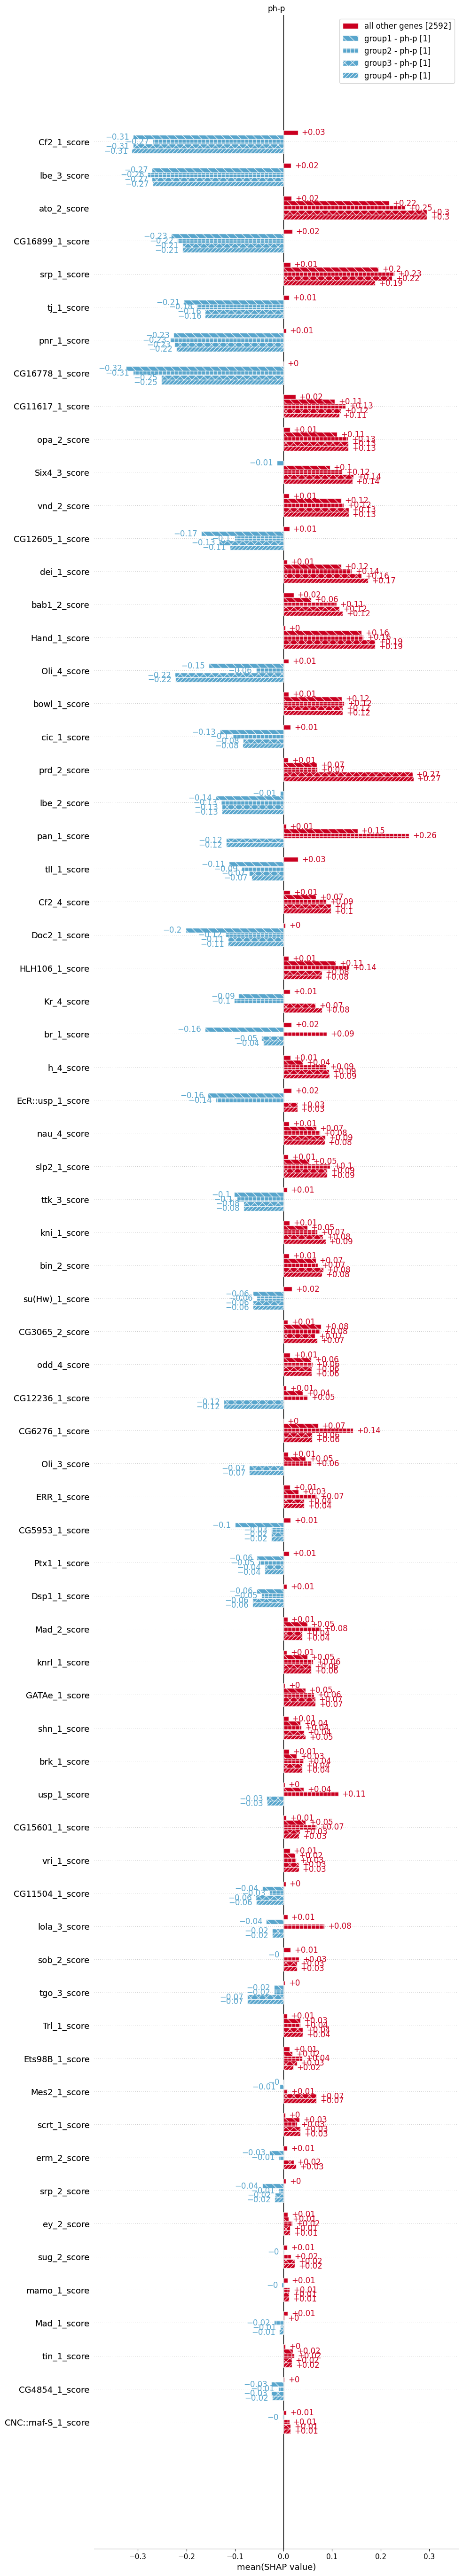

In [24]:
# get features' impact on prediction for ph-p - combined dataset of ORESAM

# set group 1 and 2 denotation in index to 3 and 4 in the ORESAM dataset -> group1: FR, group2: ZI, group3: ORE, group4: SAM
data_ORESAM.index = data_ORESAM.index.str.replace('_1', '_3', regex=False)
data_ORESAM.index = data_ORESAM.index.str.replace('_2', '_4', regex=False)
# combine datasets
data_FRZIORESAM = pd.concat([data_FRZI, data_ORESAM])

# plot
get_individual_bar_cohort(xgb_opt_trained, data_FRZIORESAM , sel_features, 'ph-p', n_features=70, figsize=(10,70), filename='figures/FRZIORSAM_xgb_opt_shap_php_cohort_plot.svg')

In [25]:
# get features that for which FR has the most negative SHAP value:

# df of shap values for all 4 groups (FR, ZI, ORE, SAM)
shap_values_FRZIORESAM_df = pd.DataFrame(explainer(data_FRZIORESAM[sel_features]).values, columns=sel_features, index=data_FRZIORESAM.index)
# extract shap values for ph-p observations 
shap_values_FRZIORESAM_df_php = shap_values_FRZIORESAM_df.loc[[idx for idx in data_FRZIORESAM.index if 'ph-p' in idx]]

# get min shap value for each feature
min_values = shap_values_FRZIORESAM_df_php.min() 
# features for which FR (group1) has min value
features_FR_min = min_values[min_values == shap_values_FRZIORESAM_df_php.iloc[0]].index.tolist() 

# get shap value difference between group1 and min value of the other 3 groups
difference_FR_to_minZIORESAM = shap_values_FRZIORESAM_df_php.iloc[0] - shap_values_FRZIORESAM_df_php.iloc[1:].min()
# rank  features for which FR (group1) has min value according to difference to min of other 3 groups - TOP10
difference_FR_to_minZIORESAM[features_FR_min].sort_values()[:10]



br_1_score        -0.115913
Doc2_1_score      -0.082323
CG5953_1_score    -0.074866
bab1_2_score      -0.052392
h_4_score         -0.048752
slp2_1_score      -0.037255
CG12605_1_score   -0.036528
ato_2_score       -0.032882
sob_2_score       -0.028385
cic_1_score       -0.026936
dtype: float32

The identified features have the most significant impact on the expression of *ph-p*, resulting in a classification of class 0 (no overexpression at lower temperatures) for FR flies and class 1 (overexpression at lower temperatures) for ZI, ORE, and SAM flies.Since the actual and predicted classes are overlapping, the corresponding transcription factors (TFs) are likely to play a role in reducing overexpression at lower temperatures in FR flies.

#### Features' impact on prediction for specific genes - bar and waterfall plots:

In [26]:
# function for bar plots
def get_individual_bar(model, data, features, gene, n_features=20, figsize=(16,8), filename=None):
    '''
    Generates and displays side-by-side bar plots showing the individual impact of features on model predictions for two data points associated 
    with a specified gene. It uses SHAP values to quantify the impact. The function identifies data points corresponding to the specified gene, 
    calculates and prints both the predicted and actual values for these points, and then calculates SHAP values for the specified features. 
    Two side-by-side SHAP value bar plots are generated for the top N features affecting the first two instances of the specified gene in the dataset.

    Args:
        model (Any): The trained machine learning model compatible with SHAP, used for making predictions and computing SHAP values.
        data (DataFrame): The DataFrame containing the dataset with features and the target column, as well as an index including the gene name.
        features (list): The list of feature names in the data used for making predictions.
        gene (str): Gene name. The function will focus on data points related to this gene.
        n_features (int, optional): The number of top features to display in the SHAP values bar plot. Defaults to 20.
        figsize (tuple, optional): The figure size for the plot, specified as (width, height). Defaults to (16, 8).
        filename (str, optional): If provided, the plot will be saved to the specified file path. Otherwise, the plot is displayed and not saved.

    Outputs:
        This function directly prints the predicted and actual values for the specified gene and generates and displays side-by-side 
        bar plots showing the mean absolute SHAP values for the top N features, highlighting their impact on model predictions for the first two 
        instances/groups associated with the specified gene. If a filename is provided, the plot is saved to the specified file.
    '''

    print(f'{gene}:\n')

    # get gene-specifc indices and their iloc
    idx = sorted([idx for idx in data.index if gene in idx])
    ilocs = [data.index.get_loc(idx) for idx in data.index if gene in idx]

    # print predicted
    print('Predicted:')
    print(pd.Series(model.predict(data[features])[ilocs], index=idx))

    # print actual
    print('\nActual:')
    print(data.loc[idx]['TSE'])

    # calculate SHAP values
    explainer = shap.TreeExplainer(model)
    shap_vals = explainer(data[features])

    # plot 
    fig = plt.figure()

    ax0 = fig.add_subplot(121) # group 1 plot
    shap.plots.bar(
    shap_vals[ilocs[0]],
    max_display=n_features,
    show = False
    )

    ax0.set_title(f'Group1 - {gene}') 

    ax1 = fig.add_subplot(122)  # group 2 plot
    shap.plots.bar(
    shap_vals[ilocs[1]],
    max_display=n_features,
    show=False,
    )
    
    ax1.set_title(f'Group2 - {gene}') 

    plt.gcf().set_size_inches(figsize)
    plt.tight_layout()
    
    # save plot
    if filename:
        plt.savefig(filename) 

    plt.show()

In [27]:
# function for waterfall plots
def get_individual_waterfall(model, data, features, gene, n_features=20, figsize=(16,8), filename=None):
    '''
    Generates and displays side-by-side waterfall plots showing the individual impact of features on model predictions for two data points associated 
    with a specified gene. It uses SHAP values to quantify the impact. The function identifies data points corresponding to the specified gene, 
    calculates and prints both the predicted and actual values for these points, and then calculates SHAP values for the specified features. 
    Two side-by-side SHAP value bar plots are generated for the top N features affecting the first two instances of the specified gene in the dataset.

    Args:
        model (Any): The trained machine learning model compatible with SHAP, used for making predictions and computing SHAP values.
        data (DataFrame): The DataFrame containing the dataset with features and the target column, as well as an index including the gene name.
        features (list): The list of feature names in the data used for making predictions.
        gene (str): Gene name. The function will focus on data points related to this gene.
        n_features (int, optional): The number of top features to display in the SHAP values bar plot. Defaults to 20.
        figsize (tuple, optional): The figure size for the plot, specified as (width, height). Defaults to (16, 8).
        filename (str, optional): If provided, the plot will be saved to the specified file path. Otherwise, the plot is displayed and not saved.

    Outputs:
        This function directly prints the predicted and actual values for the specified gene and generates and displays side-by-side 
        waterfall plots showing the mean absolute SHAP values for the top N features, highlighting their impact on model predictions 
        for the first two instances/groups associated with the specified gene. If a filename is provided, the plot is saved to the specified file.
    '''
    
    print(f'{gene}:\n')

    # get gene-specifc indices and their iloc
    idx = sorted([idx for idx in data.index if gene in idx])
    ilocs = [data.index.get_loc(idx) for idx in data.index if gene in idx]

    # print predicted
    print('Predicted:')
    print(pd.Series(model.predict(data[features])[ilocs], index=idx))

    # print actual
    print('\nActual:')
    print(data.loc[idx]['TSE'])

    # calculate SHAP values
    explainer = shap.TreeExplainer(model)
    shap_vals = explainer(data[features])

    # plot 
    fig = plt.figure()

    ax0 = fig.add_subplot(121) # group 1 plot
    shap.plots.waterfall(
    shap_vals[ilocs[0]],
    max_display=n_features,
    show = False
    )
    
    ax0.set_title(f'Group1 - {gene}') 

    ax1 = fig.add_subplot(122)  # group 2 plot
    shap.plots.waterfall(
    shap_vals[ilocs[1]],
    max_display=n_features,
    show=False,
    )

    ax1.set_title(f'Group2 - {gene}') 

    plt.gcf().set_size_inches(figsize)
    plt.tight_layout()
    
    # save plot
    if filename:
        plt.savefig(filename) 

    plt.show()

Features' impact on prediction for ph-p:

ph-p:

Predicted:
X_2126210_2138371_ph-p_1    0
X_2126210_2138371_ph-p_2    1
dtype: int64

Actual:
X_2126210_2138371_ph-p_1    0
X_2126210_2138371_ph-p_2    1
Name: TSE, dtype: int64


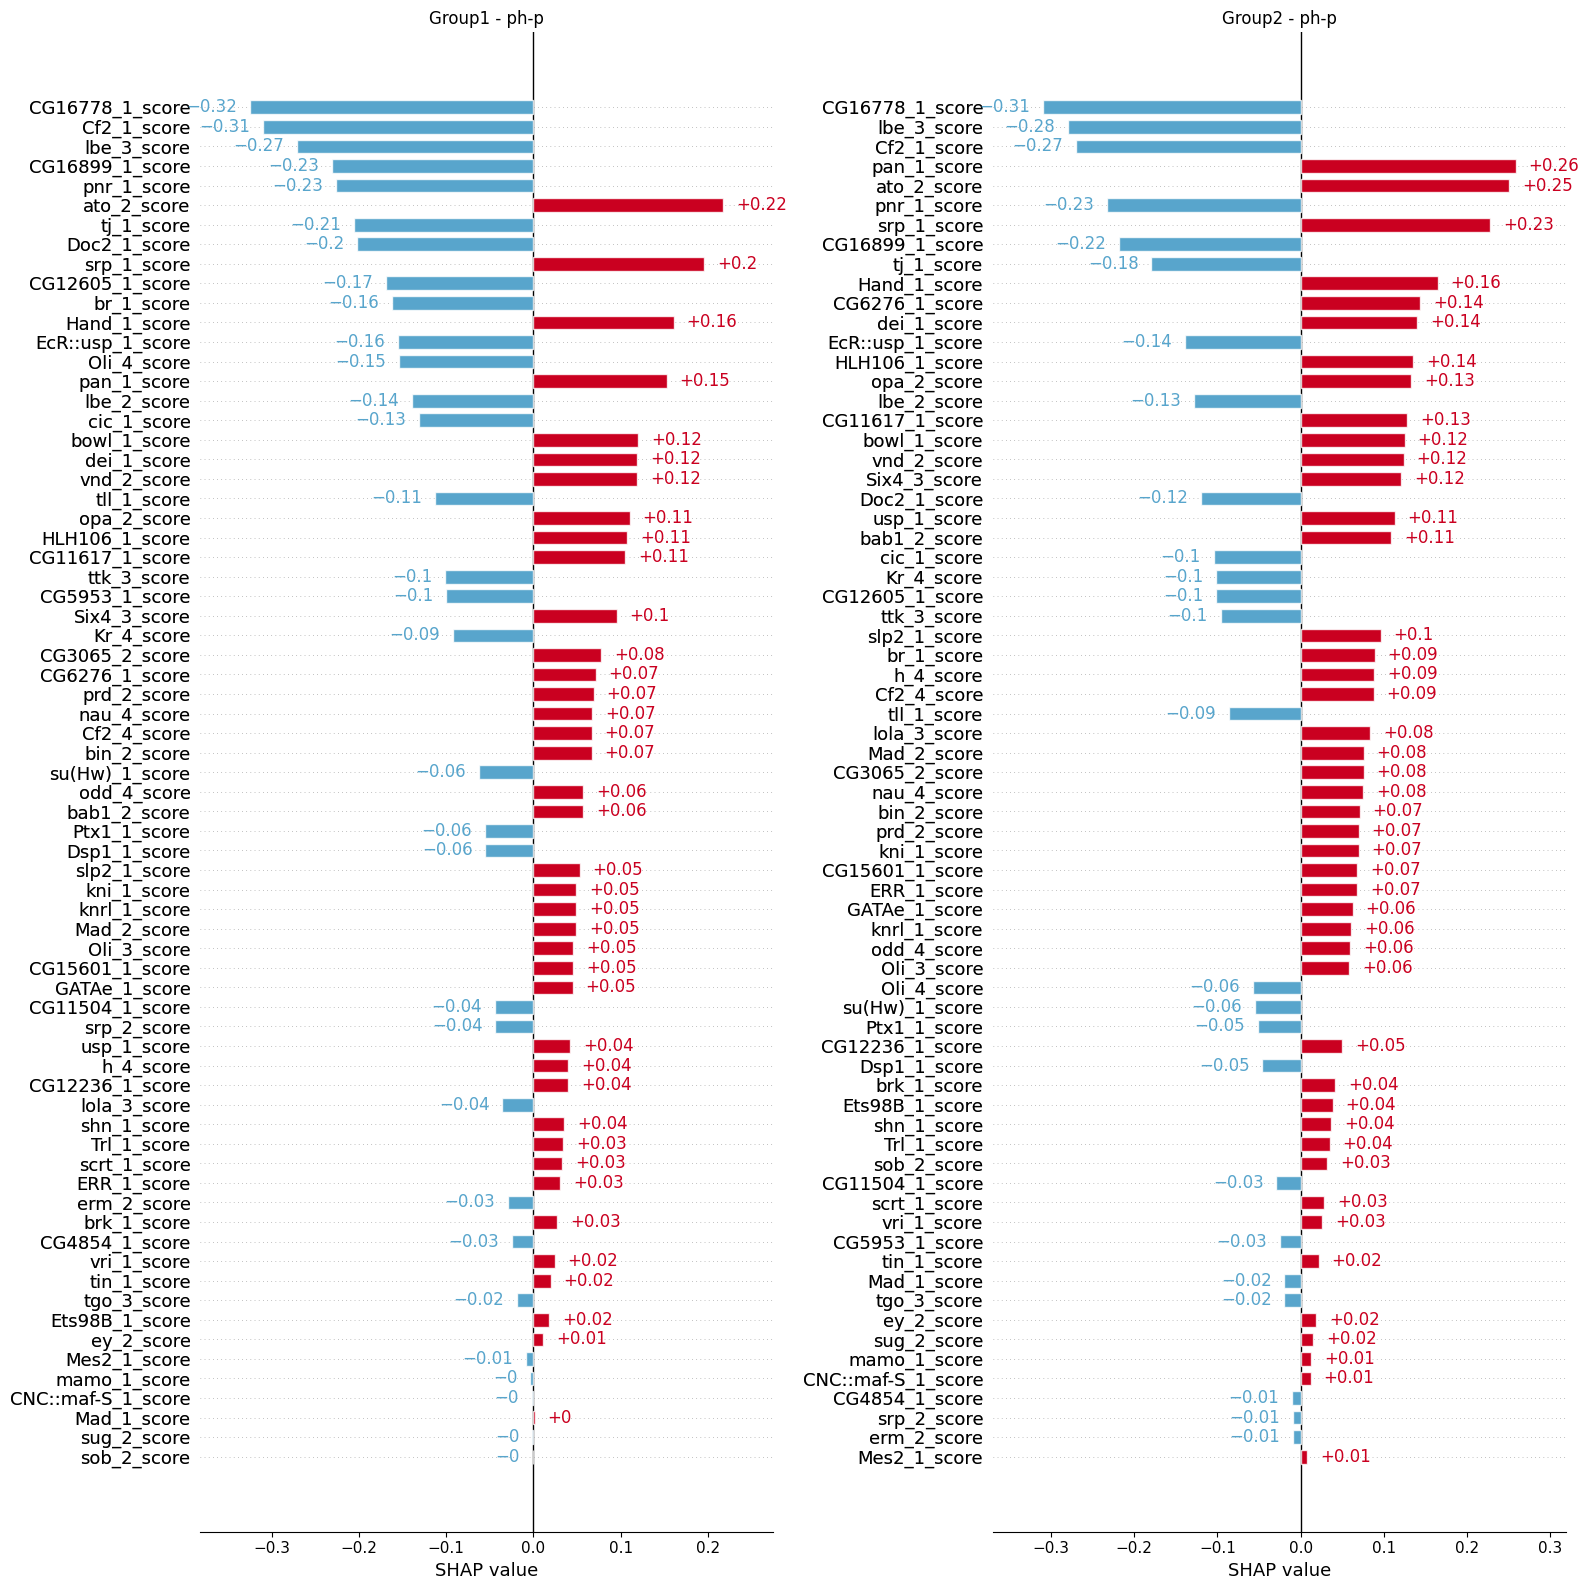

ph-p:

Predicted:
X_4126210_4138371_ph-p_3    1
X_4126210_4138371_ph-p_4    1
dtype: int64

Actual:
X_4126210_4138371_ph-p_3    1
X_4126210_4138371_ph-p_4    1
Name: TSE, dtype: int64


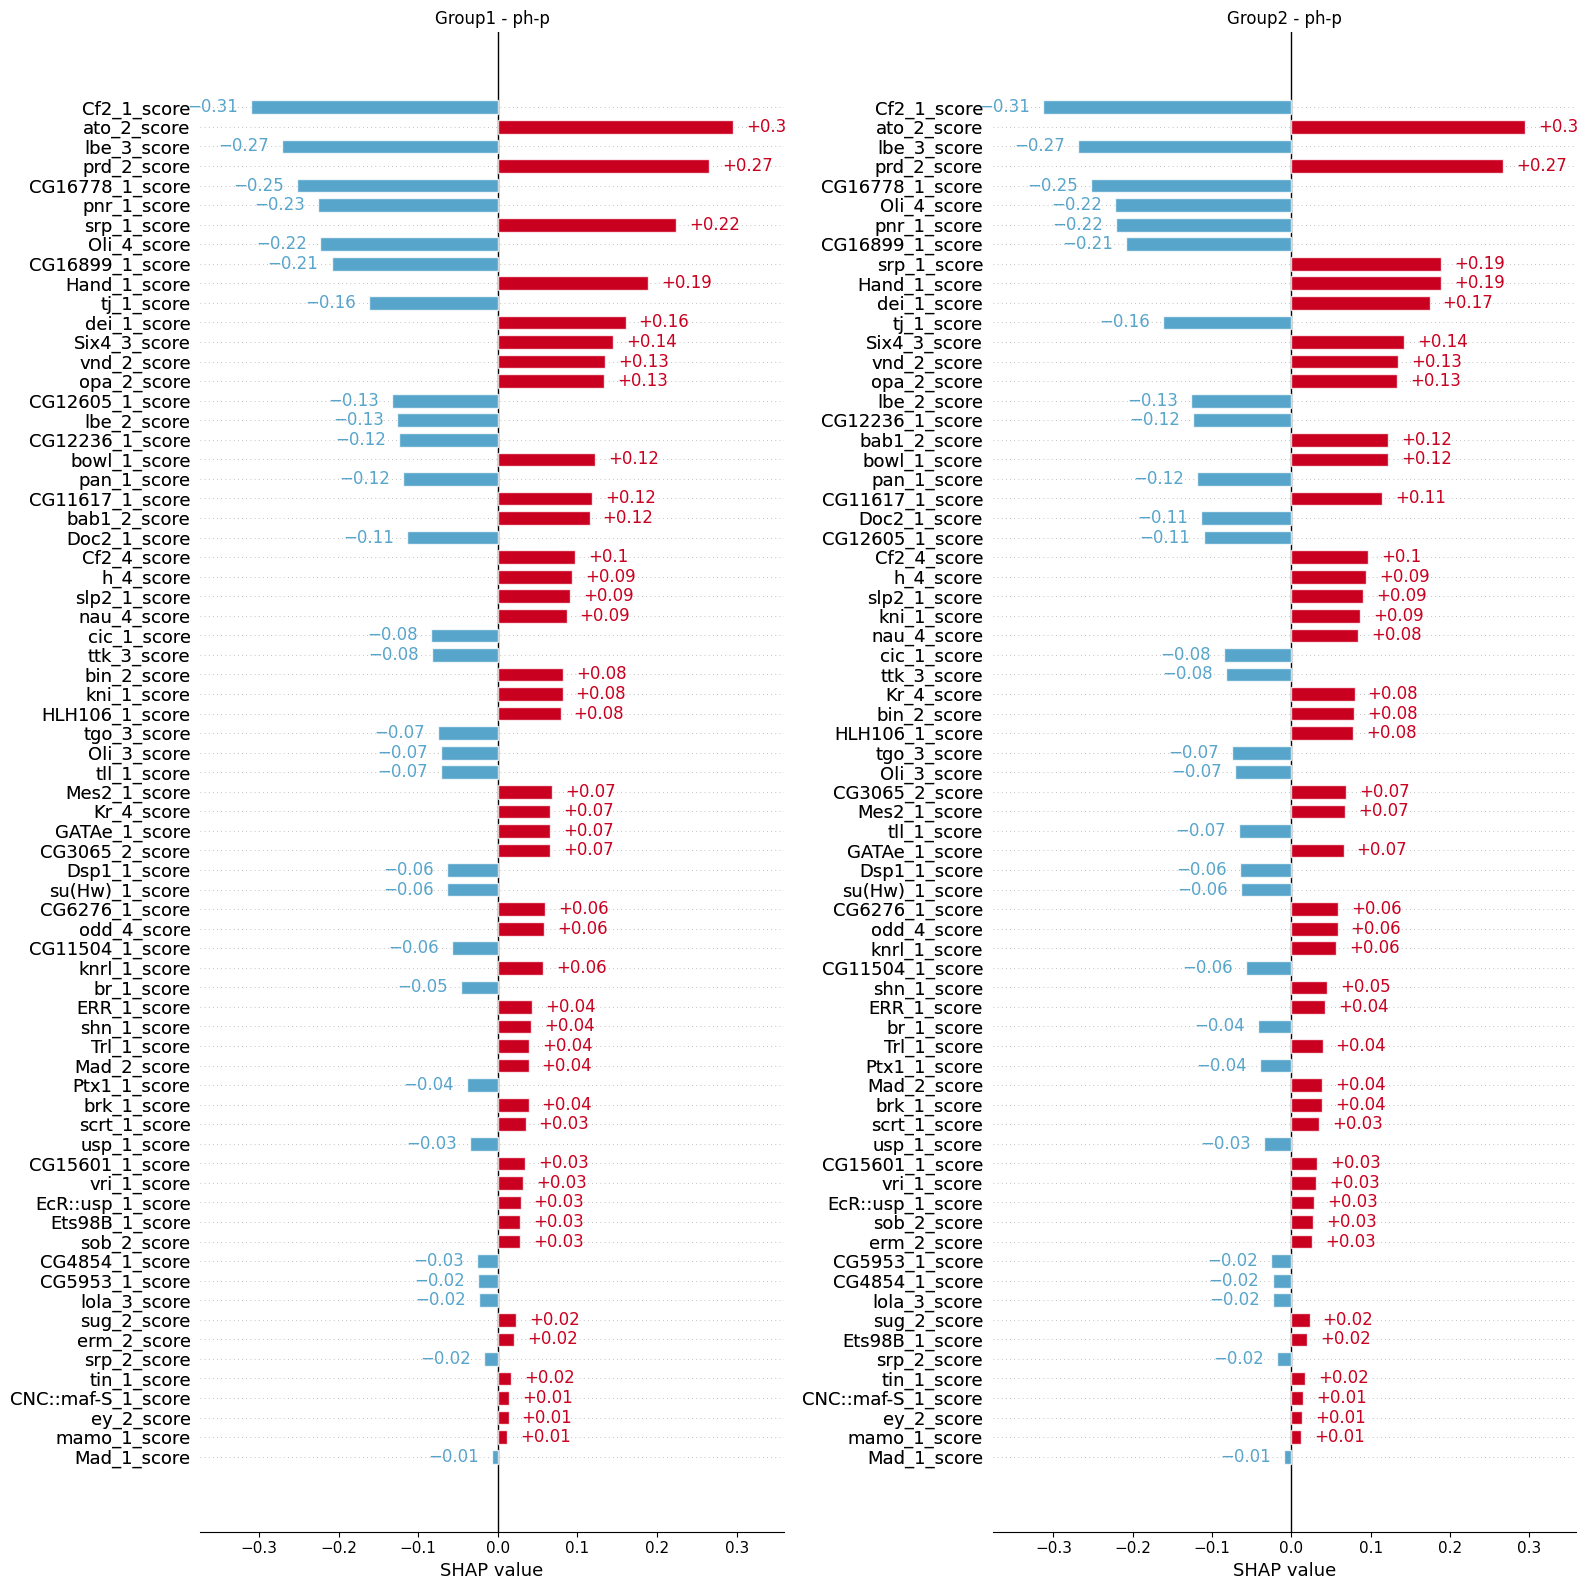

In [28]:
get_individual_bar(xgb_opt_trained, data_FRZI, sel_features, 'ph-p', n_features=70, figsize=(16,16), filename='figures/FRZI_xgb_opt_shap_php_bar.svg')
get_individual_bar(xgb_opt_trained, data_ORESAM, sel_features, 'ph-p', n_features=70, figsize=(16,16), filename='figures/ORSAM_xgb_opt_shap_php_bar.svg')

ph-p:

Predicted:
X_2126210_2138371_ph-p_1    0
X_2126210_2138371_ph-p_2    1
dtype: int64

Actual:
X_2126210_2138371_ph-p_1    0
X_2126210_2138371_ph-p_2    1
Name: TSE, dtype: int64


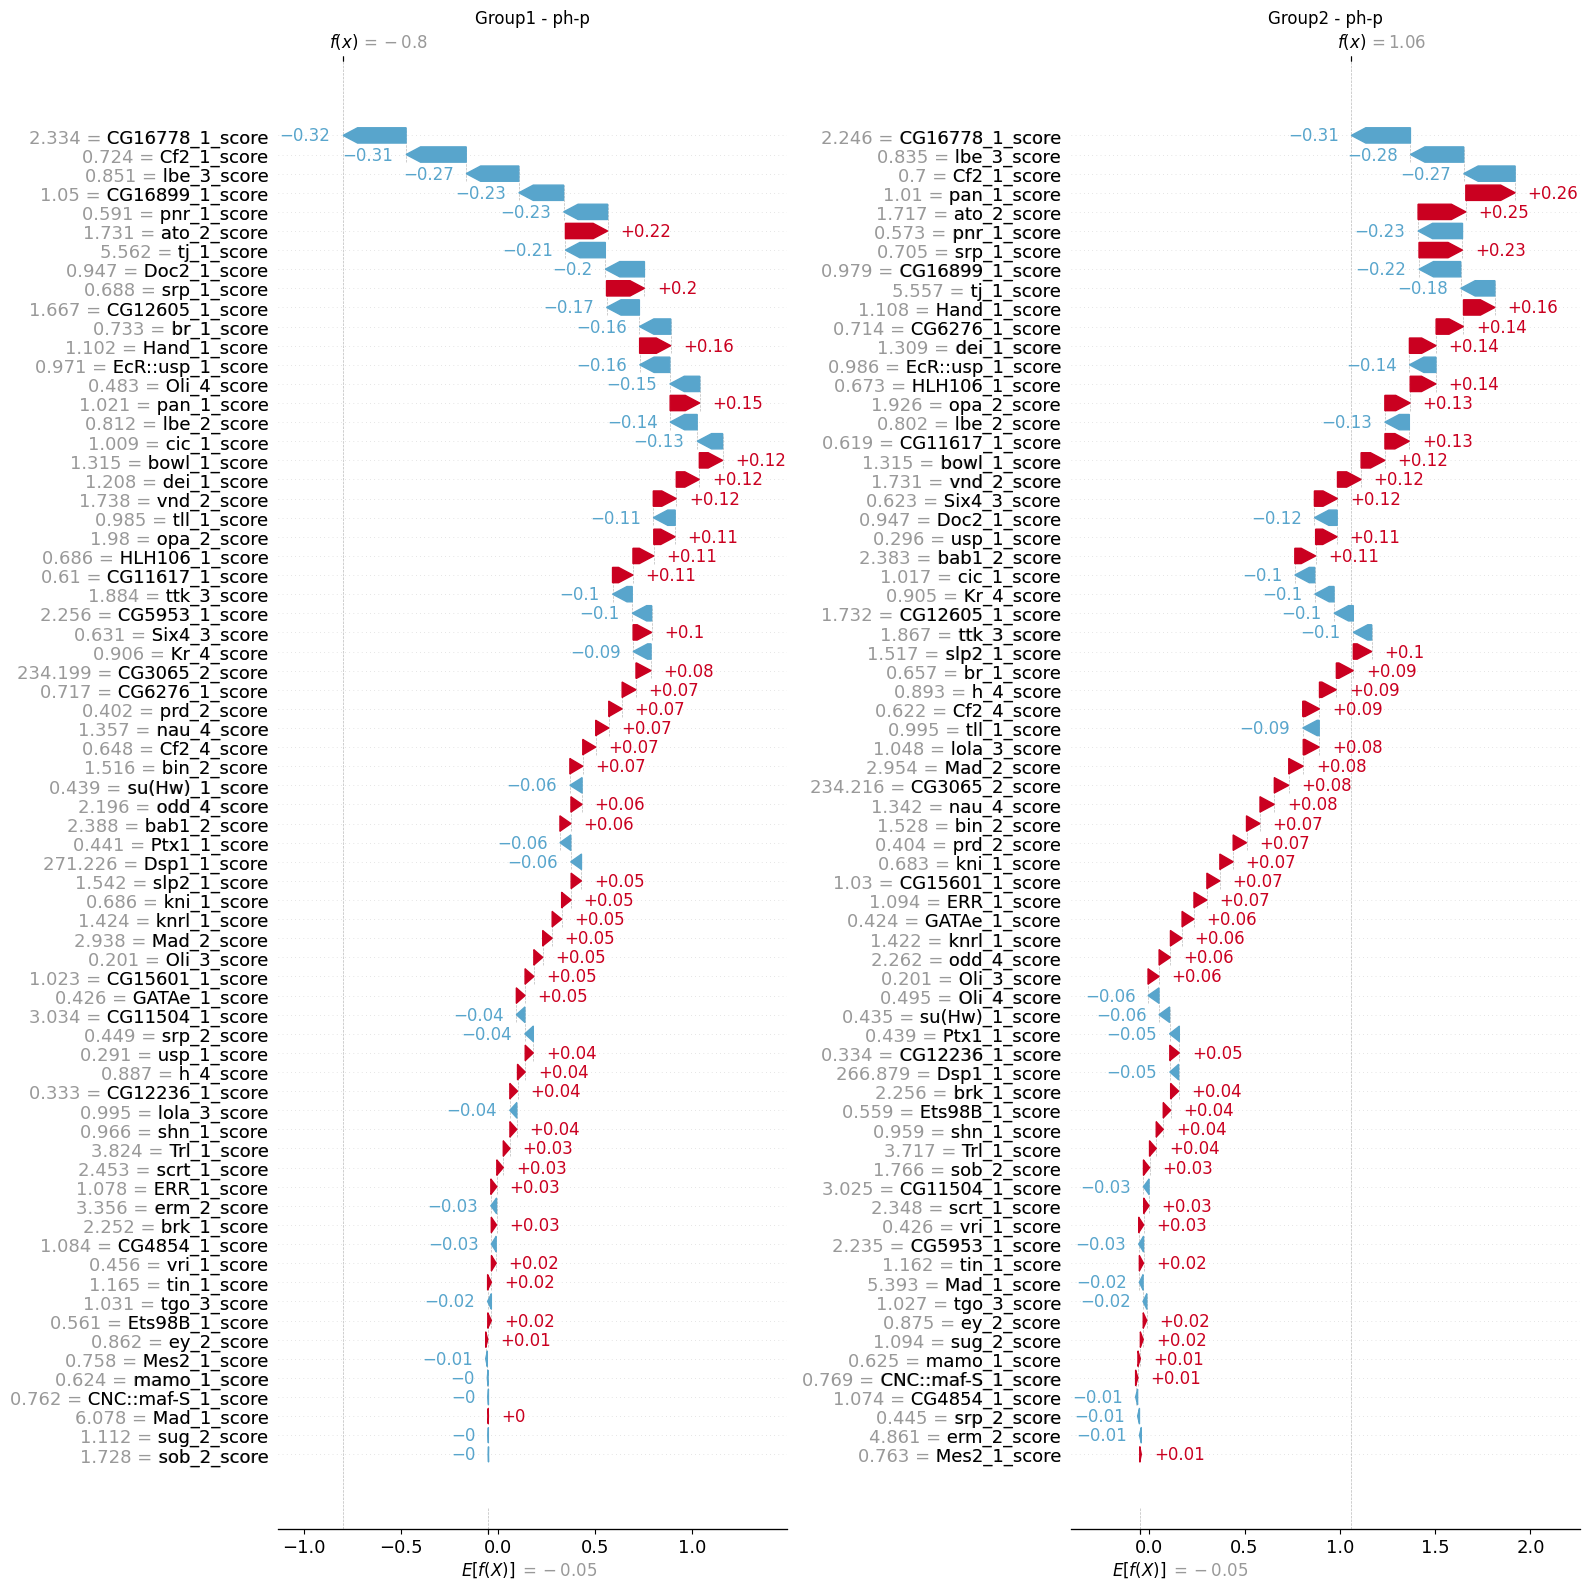

ph-p:

Predicted:
X_4126210_4138371_ph-p_3    1
X_4126210_4138371_ph-p_4    1
dtype: int64

Actual:
X_4126210_4138371_ph-p_3    1
X_4126210_4138371_ph-p_4    1
Name: TSE, dtype: int64


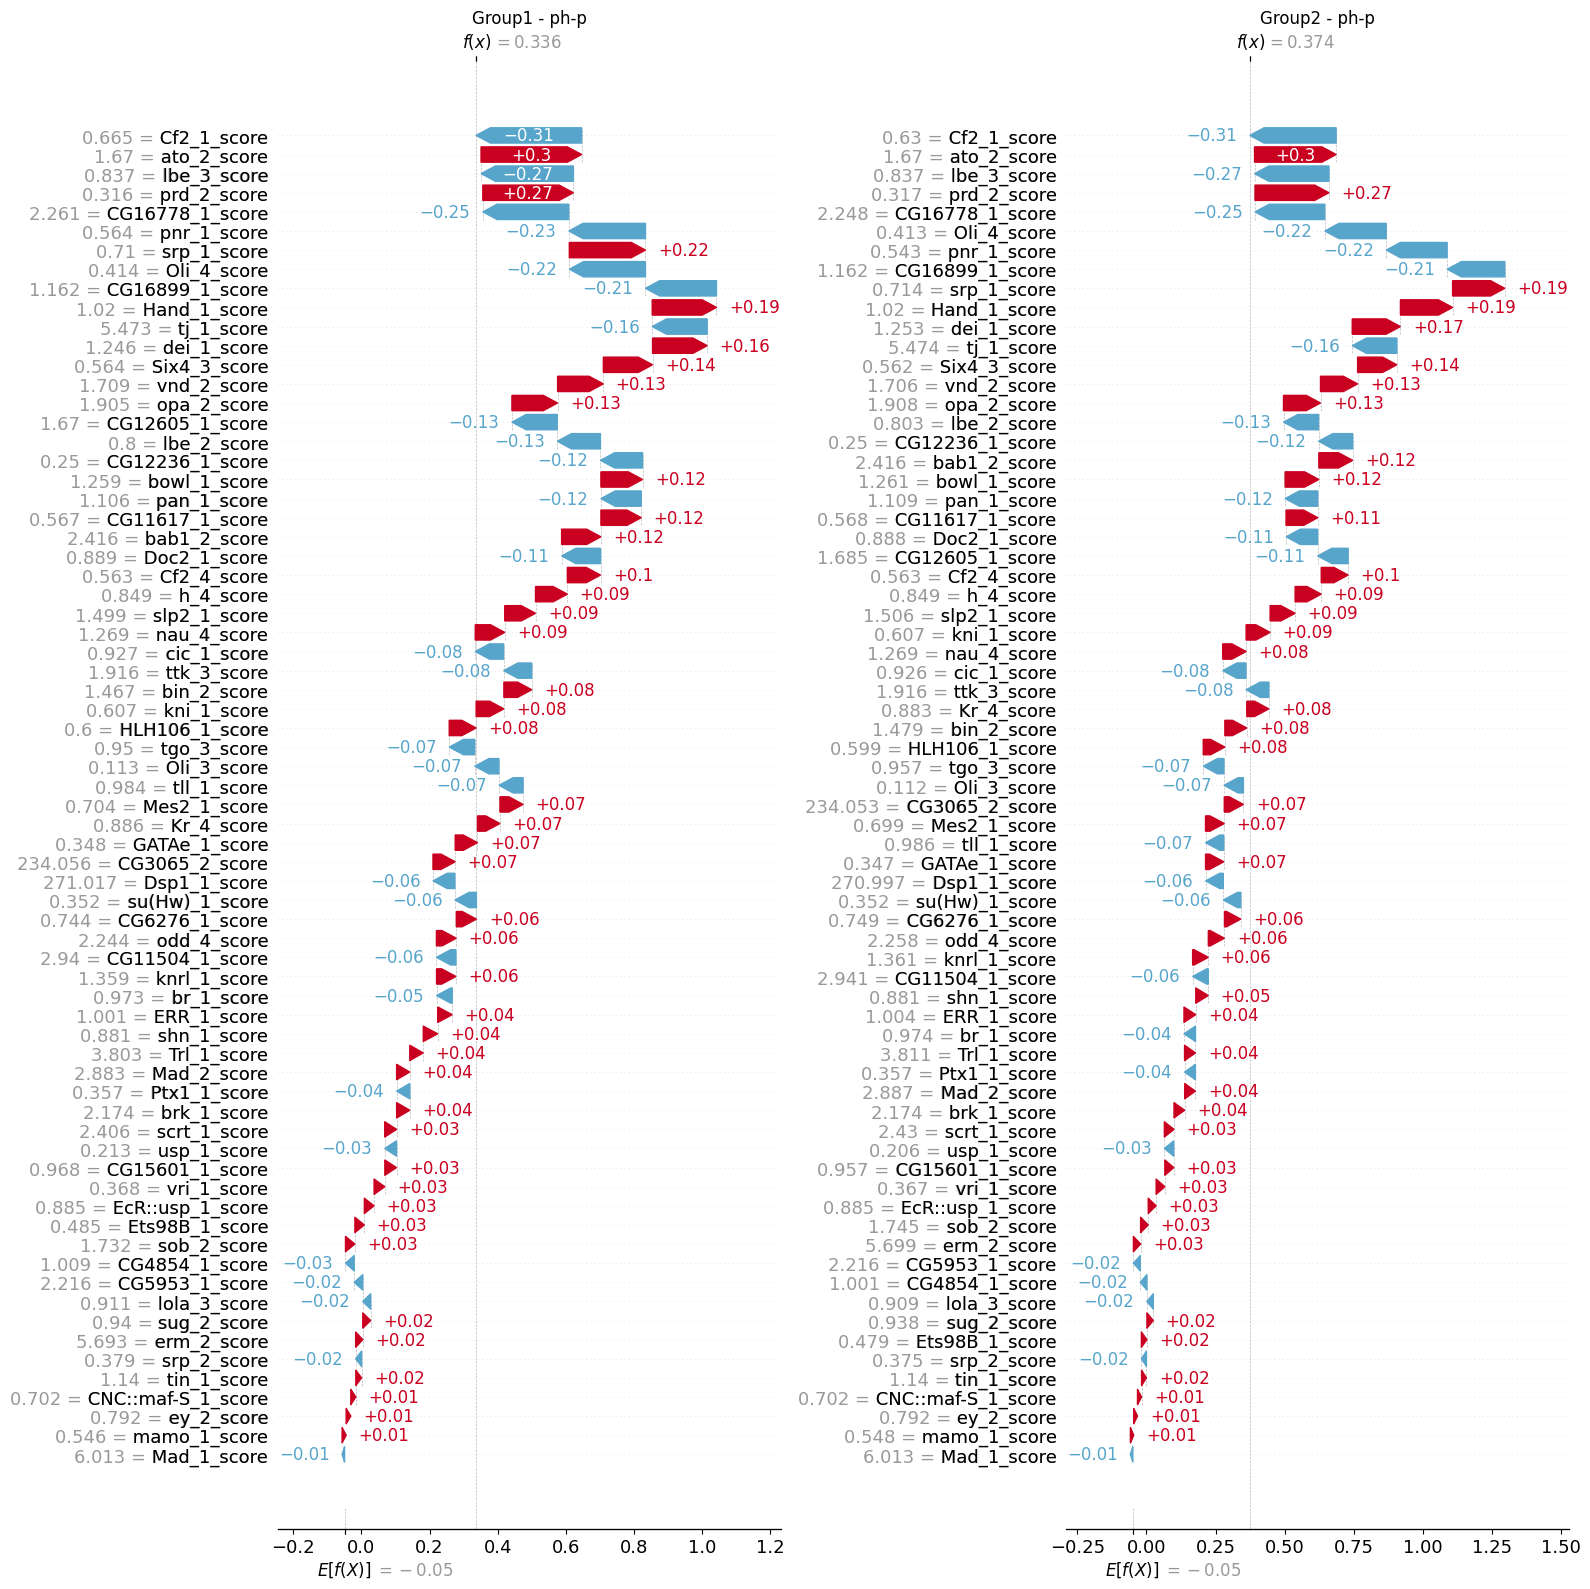

In [29]:
get_individual_waterfall(xgb_opt_trained, data_FRZI, sel_features, 'ph-p', n_features=70, figsize=(16,16), filename='figures/FRZI_xgb_opt_shap_php_waterfall.svg')
get_individual_waterfall(xgb_opt_trained, data_ORESAM, sel_features, 'ph-p', n_features=70, figsize=(16,16), filename='figures/ORESAM_xgb_opt_shap_php_waterfall.svg')

ph-p:

Predicted:
X_4126210_4138371_ph-p_3    1
X_4126210_4138371_ph-p_4    1
dtype: int64

Actual:
X_4126210_4138371_ph-p_3    1
X_4126210_4138371_ph-p_4    1
Name: TSE, dtype: int64


 98%|===================| 1083/1108 [00:29<00:00]        

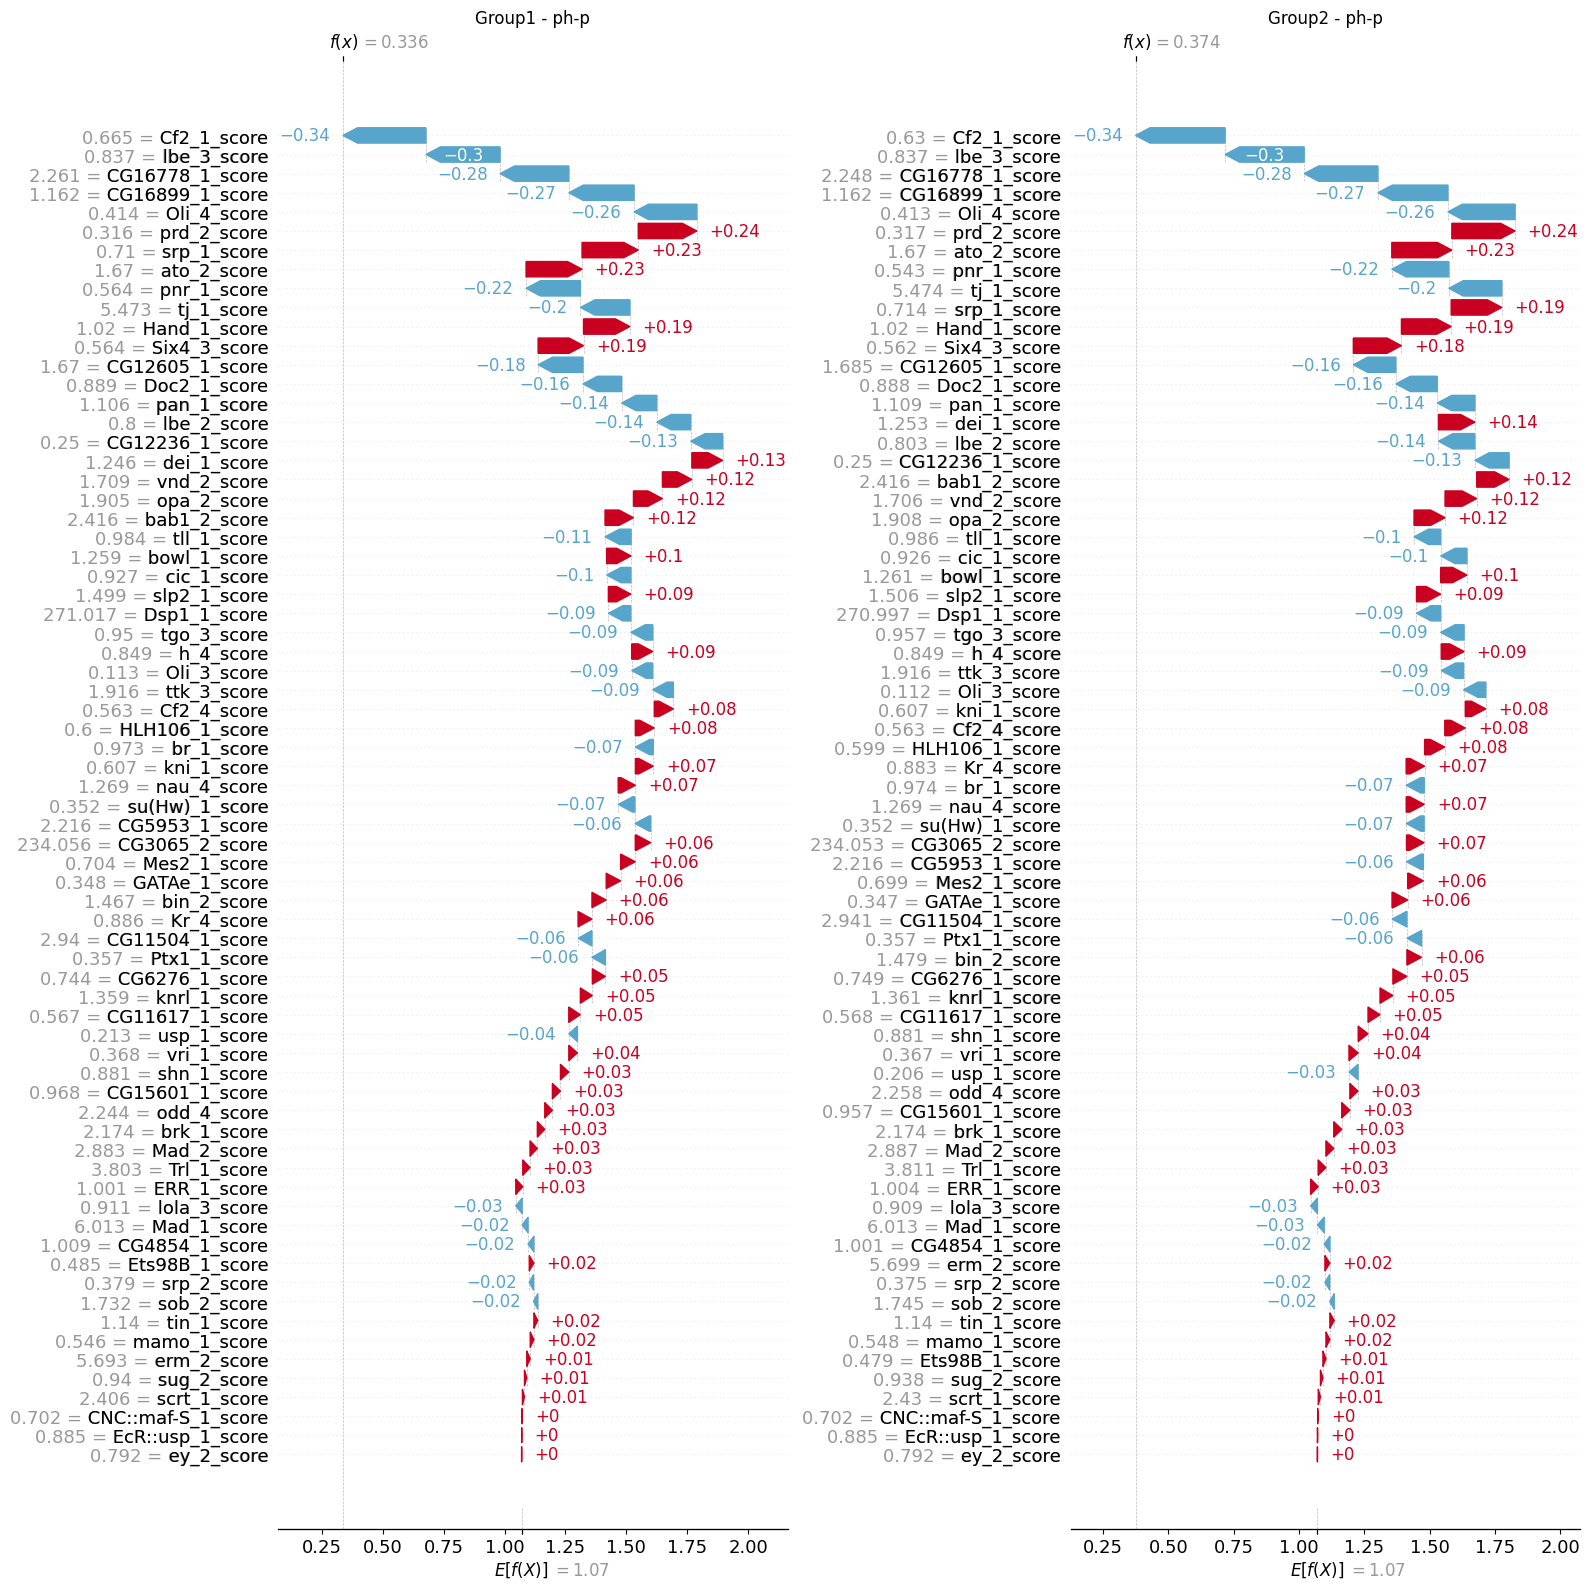

In [123]:
get_individual_waterfall(xgb_opt_trained, data_ORESAM, sel_features, 'ph-p', n_features=70, figsize=(16,16), filename='figures/ORESAM_xgb_opt_shap_php_waterfall.pdf')

 ---
###### The versions of the software used in this notebook were as follows:

###### joblib: 1.3.2 - matplotlib: 3.8.3 - numpy: 1.26.4 - pandas: 2.2.0 - python: 3.9.16 - seaborn: 0.13.2 - shap: 0.44.1


